# EcoSort Waste Management Assistant
# Module 8 Summative Lab

## Overview

You are a data scientist at "EcoSort," a technology company that specializes in developing AI solutions for waste management. EcoSort has partnered with Metro City's waste management department to develop an intelligent waste management assistant that can help residents properly dispose of waste items so less time is spent sorting material at facilities.

This assistant needs to:

1. Identify waste materials from images uploaded by residents (CNN)
2. Classify waste items based on text descriptions provided by residents (RNN/Transformer)
3. Generate specific recycling instructions based on identified waste type and city policies (Generative Transformer with RAG)

Your task is to build this integrated system using the RealWaste dataset along with generated text data that simulates real-world waste management operations.

## Part 1: Dataset Exploration and Preparation

In this section, you will explore and prepare the datasets for your models.

### 1.1 Load and Explore the RealWaste Dataset

Total images: 4752
Num classes : 9
Classes     : Cardboard, Food Organics, Glass, Metal, Miscellaneous Trash, Paper, Plastic, Textile Trash, Vegetation


,count
label,
Cardboard,461
Food Organics,411
Glass,420
Metal,790
Miscellaneous Trash,495
Paper,500
Plastic,921
Textile Trash,318
Vegetation,436


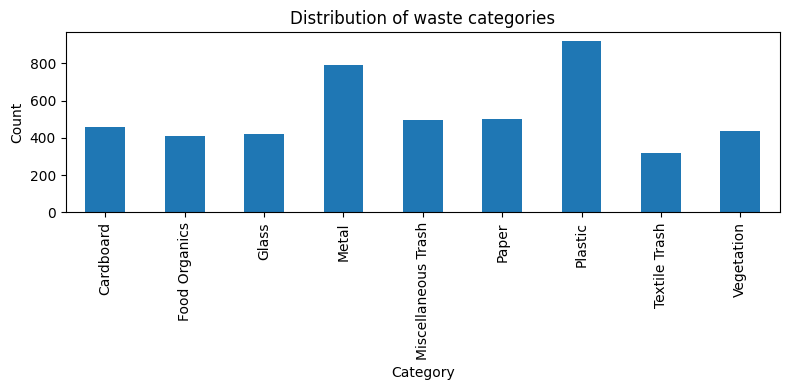

In [ ]:
# ==== 1.1 Load and Explore the RealWaste Dataset ====

# --- Standard library ---
import os, sys, io, re, json, time, random, itertools, math, glob, traceback
from pathlib import Path
from dataclasses import dataclass, asdict
from typing import Any, Dict, List, Optional, Tuple
from collections import Counter, defaultdict

# --- Scientific stack ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# --- Persistence / utilities ---
import joblib

# --- Scikit-learn (classic ML + metrics + features) ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    precision_recall_fscore_support
)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from scipy.sparse import hstack

# Reproducibility
np.random.seed(42)
random.seed(42)
try:
    import tensorflow as tf
    tf.random.set_seed(42)
except Exception:
    pass

# ---- CONFIG: set your images root here
IMAGES_ROOT = Path("/Users/Kseniya/Downloads/realwaste-main/RealWaste")  # change if needed

IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp")

def list_images_by_class(root: Path):
    rows = []
    if not root.exists():
        return pd.DataFrame(columns=["path","label","width","height","aspect","area","sharpness","colorfulness"])
    for cls_dir in sorted([p for p in root.iterdir() if p.is_dir()]):
        label = cls_dir.name
        for p in cls_dir.rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                rows.append({"path": str(p), "label": label})
    return pd.DataFrame(rows)

def pil_read_size(p: str):
    try:
        with Image.open(p) as im:
            im = im.convert("RGB")
            w, h = im.size
            return w, h
    except Exception:
        return None, None

def variance_of_laplacian_np(img_rgb: np.ndarray) -> float:
    """Sharpness proxy without OpenCV. img_rgb: HxWx3 (0..255)."""
    # convert to gray
    g = (0.299*img_rgb[...,0] + 0.587*img_rgb[...,1] + 0.114*img_rgb[...,2]).astype(np.float32)
    # 3x3 Laplacian kernel
    k = np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=np.float32)
    # pad and convolve
    pad = 1
    gp = np.pad(g, pad, mode="edge")
    H, W = g.shape
    out = np.zeros_like(g)
    for i in range(H):
        for j in range(W):
            region = gp[i:i+3, j:j+3]
            out[i,j] = np.sum(region * k)
    return float(out.var())

def colorfulness_hasler(img_rgb: np.ndarray) -> float:
    """Hasler & Suesstrunk colorfulness metric."""
    R, G, B = img_rgb[...,0].astype(np.float32), img_rgb[...,1].astype(np.float32), img_rgb[...,2].astype(np.float32)
    rg = np.abs(R - G)
    yb = np.abs(0.5*(R + G) - B)
    std_rg, std_yb = rg.std(), yb.std()
    mean_rg, mean_yb = rg.mean(), yb.mean()
    return math.sqrt(std_rg**2 + std_yb**2) + 0.3*math.sqrt(mean_rg**2 + mean_yb**2)

def compute_image_stats(df: pd.DataFrame, sample_for_quality=300):
    """Adds width/height/aspect/area + sharpness & colorfulness (on a sample to save time)."""
    ws, hs = [], []
    for p in df["path"]:
        w, h = pil_read_size(p)
        ws.append(w); hs.append(h)
    df["width"], df["height"] = ws, hs
    df = df.dropna(subset=["width","height"])
    df["width"] = df["width"].astype(int)
    df["height"] = df["height"].astype(int)
    df["aspect"] = (df["width"] / df["height"]).round(4)
    df["area"] = df["width"] * df["height"]

    # quality metrics on a subset
    idxs = df.sample(min(sample_for_quality, len(df)), random_state=42).index if len(df) else []
    sharpness = pd.Series(np.nan, index=df.index, dtype=float)
    colorfulness = pd.Series(np.nan, index=df.index, dtype=float)
    for i in idxs:
        try:
            with Image.open(df.loc[i,"path"]) as im:
                im = im.convert("RGB")
                arr = np.array(im)
            sharpness[i] = variance_of_laplacian_np(arr)
            colorfulness[i] = colorfulness_hasler(arr)
        except Exception:
            pass
    df["sharpness"] = sharpness
    df["colorfulness"] = colorfulness
    return df

def show_examples(df: pd.DataFrame, per_class=3, img_size=160):
    classes = sorted(df["label"].unique())
    for cls in classes:
        sub = df[df["label"] == cls].sample(min(per_class, len(df[df["label"]==cls])), random_state=42)
        if len(sub)==0: 
            continue
        plt.figure(figsize=(per_class*2.3, 2.3))
        for i, (_, row) in enumerate(sub.iterrows(), start=1):
            plt.subplot(1, len(sub), i)
            try:
                im = Image.open(row["path"]).convert("RGB")
                im = im.resize((img_size, img_size))
                plt.imshow(im)
                plt.title(cls, fontsize=9)
                plt.axis("off")
            except Exception:
                pass
        plt.tight_layout()
        plt.show()

# ---- Run exploration
df = list_images_by_class(IMAGES_ROOT)

if len(df) == 0:
    print(f"[!] No images found under: {IMAGES_ROOT.resolve()}")
    print("Expected layout: data/images/<class_name>/*.jpg ... with classes:")
    print("paper, cardboard, biological, metal, plastic, green-glass, brown-glass, white-glass")
else:
    # Basic structure
    print("Total images:", len(df))
    print("Num classes :", df['label'].nunique())
    print("Classes     :", ", ".join(sorted(df['label'].unique().tolist())))

    # Category distribution
    counts = df["label"].value_counts().sort_index()
    display(pd.DataFrame({"count": counts}))

    plt.figure(figsize=(8,4))
    counts.plot(kind="bar")
    plt.title("Distribution of waste categories")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

    # Image characteristics
    df = compute_image_stats(df)

    # Resolution histogram (area)
    plt.figure(figsize=(8,4))
    (df["area"]).plot(kind="hist", bins=30)
    plt.title("Image area (pixels) distribution")
    plt.xlabel("width * height")
    plt.tight_layout()
    plt.show()

    # Aspect ratio histogram
    plt.figure(figsize=(8,4))
    df["aspect"].plot(kind="hist", bins=30)
    plt.title("Aspect ratio distribution (width/height)")
    plt.xlabel("Aspect ratio")
    plt.tight_layout()
    plt.show()

    # Sharpness (variance of Laplacian) on sample
    if df["sharpness"].notna().sum() > 0:
        plt.figure(figsize=(8,4))
        df["sharpness"].dropna().plot(kind="hist", bins=30)
        plt.title("Sharpness distribution (variance of Laplacian, sample)")
        plt.xlabel("Sharpness")
        plt.tight_layout()
        plt.show()
        print("Sharpness (sample) — mean:", round(df["sharpness"].mean(), 3),
              "median:", round(df["sharpness"].median(), 3))

    # Colorfulness on sample
    if df["colorfulness"].notna().sum() > 0:
        plt.figure(figsize=(8,4))
        df["colorfulness"].dropna().plot(kind="hist", bins=30)
        plt.title("Colorfulness distribution (sample)")
        plt.xlabel("Colorfulness")
        plt.tight_layout()
        plt.show()
        print("Colorfulness (sample) — mean:", round(df["colorfulness"].mean(), 3),
              "median:", round(df["colorfulness"].median(), 3))

    # Few examples per class
    show_examples(df, per_class=3)

    # Quick summary table per class
    agg = df.groupby("label").agg(
        n=("path","count"),
        w_mean=("width","mean"),
        h_mean=("height","mean"),
        area_median=("area","median"),
        aspect_mean=("aspect","mean"),
        sharp_mean=("sharpness","mean"),
        color_mean=("colorfulness","mean"),
    ).round(2)
    display(agg)


### 1.2 Explore Text Datasets

In [ ]:
# ==== 1.2a — Explore waste_descriptions.csv ====
# This cell:
# - Locates and loads the CSV
# - Detects key columns (text/label/etc.)
# - Shows category distribution and description lengths
# - Lists top unigrams/bigrams and safe per-class TF-IDF keywords

from IPython.display import display

# Robust location (edit or add your own paths)
candidates = [
    Path("waste_descriptions.csv"),
    Path("./data/waste_descriptions.csv"),
    Path("../data/waste_descriptions.csv"),
]
desc_path = next((p for p in candidates if p.exists()), None)
if desc_path is None:
    raise FileNotFoundError("waste_descriptions.csv not found. Place it next to the notebook or in ./data.")

df = pd.read_csv(desc_path)
print("Rows:", len(df), "| Columns:", list(df.columns))

# Column picker: exact match first, then substring
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    # exact
    for want in candidates:
        for orig, n in norm.items():
            if n == want:
                return orig
    # substring
    for want in candidates:
        for orig, n in norm.items():
            if want in n:
                return orig
    return None

text_col = pick(df.columns, ["description","text","item_description","waste_description"])
label_col = pick(df.columns, ["category","label","waste_category","class"])
disp_col  = pick(df.columns, ["disposal_instruction","proper_disposal","disposal","instructions"])
conf_col  = pick(df.columns, ["common_confusion","confusion"])
comp_col  = pick(df.columns, ["material_composition","composition"])

print("Detected columns:", {"text":text_col, "label":label_col, "disposal":disp_col, "confusion":conf_col, "composition":comp_col})
assert text_col and label_col, "Need at least a text column and a label column."

# Basic cleaning
df[text_col]  = df[text_col].astype(str).str.strip()
df[label_col] = df[label_col].astype(str).str.strip()
df = df[df[text_col].str.len() > 0].drop_duplicates(subset=[text_col, label_col]).reset_index(drop=True)

# Category distribution
counts = df[label_col].value_counts().sort_index()
display(pd.DataFrame({"count": counts}))

plt.figure(figsize=(8,4))
counts.plot(kind="bar")
plt.title("Distribution of waste categories")
plt.xlabel("Category"); plt.ylabel("Count")
plt.tight_layout(); plt.show()

# Description length analysis
desc_len = df[text_col].str.split().apply(len)
print("Description length — mean:", round(desc_len.mean(),2), 
      "median:", int(desc_len.median()), 
      "max:", int(desc_len.max()))

plt.figure(figsize=(8,4))
plt.hist(desc_len, bins=30)
plt.title("Description length (words)")
plt.xlabel("Words")
plt.tight_layout(); plt.show()

# Disposal instruction length (if present)
if disp_col:
    disp_len = df[disp_col].dropna().astype(str).str.split().apply(len)
    print("Disposal instruction length — mean:", round(disp_len.mean(),2), 
          "median:", int(disp_len.median()))
    plt.figure(figsize=(8,4))
    plt.hist(disp_len, bins=30)
    plt.title("Disposal instruction length (words)")
    plt.xlabel("Words")
    plt.tight_layout(); plt.show()

# Top unigrams/bigrams (global) with safe fallback
def top_terms(corpus, n=20, ngram=(1,1), stop="english"):
    try:
        vec = CountVectorizer(lowercase=True, stop_words=stop, ngram_range=ngram, min_df=2)
        X = vec.fit_transform(corpus)
    except ValueError:
        vec = CountVectorizer(lowercase=True, stop_words=stop, ngram_range=ngram, min_df=1)
        X = vec.fit_transform(corpus)
    sums = np.asarray(X.sum(axis=0)).ravel()
    vocab = np.array(vec.get_feature_names_out())
    top_ix = np.argsort(-sums)[:min(n, sums.size)]
    return pd.DataFrame({"term": vocab[top_ix], "count": sums[top_ix]})

print("\nTop unigrams:")
display(top_terms(df[text_col], n=20, ngram=(1,1)))

print("Top bigrams:")
display(top_terms(df[text_col], n=20, ngram=(2,2)))

# SAFE per-class TF-IDF (handles small groups)
def top_tfidf_per_class_safe(frame, text_col, label_col, topk=10):
    rows = []
    for label, sub in frame.groupby(label_col):
        docs = sub[text_col].fillna("").astype(str).tolist()
        n = len(docs)
        if n == 0:
            continue

        min_df = 2 if n >= 5 else 1
        max_df = 0.9 if n >= 5 else 1.0

        vec = TfidfVectorizer(lowercase=True, stop_words="english",
                              ngram_range=(1,2), min_df=min_df, max_df=max_df)
        try:
            X = vec.fit_transform(docs)
        except ValueError:
            vec = TfidfVectorizer(lowercase=True, stop_words="english",
                                  ngram_range=(1,1), min_df=1, max_df=1.0)
            X = vec.fit_transform(docs)

        means = np.asarray(X.mean(axis=0)).ravel()
        if means.size == 0:
            continue

        top_ix = np.argsort(-means)[:min(topk, means.size)]
        vocab = np.array(vec.get_feature_names_out())
        for t, s in zip(vocab[top_ix], means[top_ix]):
            rows.append({"category": label, "term": t, "mean_tfidf": float(s)})
    return pd.DataFrame(rows)

print("\nTop TF-IDF terms per category (safe):")
display(top_tfidf_per_class_safe(df, text_col, label_col, topk=10))

In [ ]:
# ==== 1.2b — Explore waste_policy_documents (JSON only) ====
# This cell:
# - Loads policy docs from a JSON file
# - Reports document lengths, category coverage, jurisdictions/types
# - Shows top TF-IDF terms (global) and safe per-category keywords

import json
from pathlib import Path
from IPython.display import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

# Locate & load JSON (edit path if needed)
candidates = [
    Path("waste_policy_documents.json"),
    Path("./data/waste_policy_documents.json"),
    Path("../data/waste_policy_documents.json"),
]
pol_json = next((p for p in candidates if p.exists()), None)
if pol_json is None:
    raise FileNotFoundError("Policy JSON not found. Place it next to the notebook or in ./data.")

with open(pol_json, "r", encoding="utf-8") as f:
    data = json.load(f)
pdf = pd.json_normalize(data)

print("Rows:", len(pdf), "| Columns:", list(pdf.columns))

# Column detection (exact first, then substring)
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want:
                return orig
    for want in candidates:
        for orig, n in norm.items():
            if want in n:
                return orig
    return None

text_col = pick(pdf.columns, ["document_text","text","body","content"])
cats_col = pick(pdf.columns, ["categories_covered","category","categories"])
jur_col  = pick(pdf.columns, ["jurisdiction","city","region"])
type_col = pick(pdf.columns, ["policy_type","type"])
date_col = pick(pdf.columns, ["effective_date","date","updated_at"])

print("Detected columns:", {"text":text_col, "categories":cats_col, "jurisdiction":jur_col, "policy_type":type_col, "date":date_col})
assert text_col, "Need a text column for the policy content."

# Clean and de-duplicate
pdf[text_col] = pdf[text_col].fillna("").astype(str).str.strip()
pdf = pdf[pdf[text_col].str.len() > 0].drop_duplicates(subset=[text_col]).reset_index(drop=True)

# Document length distribution
pdf["_words"] = pdf[text_col].str.split().apply(len)
print("Document length (words) — mean:", round(pdf["_words"].mean(),2), 
      "median:", int(pdf["_words"].median()))

plt.figure(figsize=(8,4))
plt.hist(pdf["_words"], bins=30)
plt.title("Policy document length (words)")
plt.xlabel("Words")
plt.tight_layout(); plt.show()

# Helper to coerce category field into a list
def to_list(x):
    if isinstance(x, list):
        return x
    if pd.isna(x):
        return []
    if isinstance(x, str) and x.strip().startswith("["):
        try:
            arr = json.loads(x)
            if isinstance(arr, list):
                return arr
        except Exception:
            pass
    return [x]

# Category coverage (if available)
if cats_col:
    pdf["_categories_list"] = pdf[cats_col].apply(to_list)
    cat_rows = [{"category": c} for lst in pdf["_categories_list"] for c in lst]
    cdf = pd.DataFrame(cat_rows)
    if len(cdf):
        counts = cdf["category"].astype(str).value_counts().sort_index()
        display(pd.DataFrame({"count": counts}))
        plt.figure(figsize=(8,4))
        counts.plot(kind="bar")
        plt.title("Categories covered in policy documents")
        plt.xlabel("Category"); plt.ylabel("Count")
        plt.tight_layout(); plt.show()
else:
    pdf["_categories_list"] = [[] for _ in range(len(pdf))]

# Jurisdictions / policy types
if jur_col:
    pdf[jur_col] = pdf[jur_col].fillna("Unknown").astype(str).str.strip()
    display(pd.DataFrame({"jurisdiction_count": pdf[jur_col].value_counts()}))
if type_col:
    pdf[type_col] = pdf[type_col].fillna("Unknown").astype(str).str.strip()
    display(pd.DataFrame({"policy_type_count": pdf[type_col].value_counts()}))

# Document recency by month (optional)
if date_col:
    pdf["_date"] = pd.to_datetime(pdf[date_col], errors="coerce")
    if pdf["_date"].notna().any():
        plt.figure(figsize=(8,3))
        pdf["_date"].dt.to_period("M").value_counts().sort_index().plot(kind="bar")
        plt.title("Policy docs by month")
        plt.tight_layout(); plt.show()

# Global language profile: top TF-IDF terms (robust)
try:
    vec_global = TfidfVectorizer(lowercase=True, stop_words="english",
                                 ngram_range=(1,2), min_df=2, max_df=0.9,
                                 max_features=50000)
    Xg = vec_global.fit_transform(pdf[text_col])
except ValueError:
    vec_global = TfidfVectorizer(lowercase=True, stop_words="english",
                                 ngram_range=(1,1), min_df=1, max_df=1.0,
                                 max_features=20000)
    Xg = vec_global.fit_transform(pdf[text_col])

means_g = np.asarray(Xg.mean(axis=0)).ravel()
vocab_g = np.array(vec_global.get_feature_names_out())
top_ix_g = np.argsort(-means_g)[:min(30, means_g.size)]
display(pd.DataFrame({"term": vocab_g[top_ix_g], "mean_tfidf": means_g[top_ix_g]}))

# SAFE per-category keywords (handles small groups)
if cats_col:
    safe_rows = []
    cats = sorted({c for lst in pdf["_categories_list"] for c in lst})
    for c in cats:
        mask = pdf["_categories_list"].apply(lambda xs: c in xs)
        docs = pdf.loc[mask, text_col].tolist()
        n = len(docs)
        if n == 0:
            continue

        min_df = 2 if n >= 5 else 1
        max_df = 0.9 if n >= 5 else 1.0

        try:
            vec = TfidfVectorizer(lowercase=True, stop_words="english",
                                  ngram_range=(1,2), min_df=min_df, max_df=max_df,
                                  max_features=20000)
            Xc = vec.fit_transform(docs)
        except ValueError:
            vec = TfidfVectorizer(lowercase=True, stop_words="english",
                                  ngram_range=(1,1), min_df=1, max_df=1.0,
                                  max_features=10000)
            Xc = vec.fit_transform(docs)

        means_c = np.asarray(Xc.mean(axis=0)).ravel()
        if means_c.size == 0:
            continue

        top_ix = np.argsort(-means_c)[:min(10, means_c.size)]
        vocab_c = np.array(vec.get_feature_names_out())
        for t, s in zip(vocab_c[top_ix], means_c[top_ix]):
            safe_rows.append({"category": str(c), "term": t, "mean_tfidf": float(s)})

    if safe_rows:
        display(pd.DataFrame(safe_rows))

### 1.3 Create Data Pipelines

In [ ]:
# ==== 1.3 — Create Data Pipelines (TensorFlow, stratified train/val/test) ====
# What this cell does:
# - Scans a directory of class subfolders (e.g., RealWaste/paper, .../plastic, etc.)
# - Builds stratified splits: 70% train, 15% val, 15% test
# - Creates performant tf.data pipelines with caching/prefetch
# - Adds optional light data augmentation for training

import os, random, math, pathlib
import numpy as np
import tensorflow as tf

# Reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# ---------- CONFIG ----------
data_dir = pathlib.Path("/Users/Kseniya/Downloads/realwaste-main/RealWaste")  # <-- set this to the folder that has the 8 class subfolders
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH  = 224
TRAIN_FRAC, VAL_FRAC, TEST_FRAC = 0.70, 0.15, 0.15  # must sum to 1.0
ALLOWED_EXTS = (".jpg", ".jpeg", ".png", ".webp", ".bmp")
# ----------------------------

# Validate directory
assert data_dir.exists() and data_dir.is_dir(), f"Directory not found: {data_dir}"

# List classes (subfolders)
class_names = sorted([p.name for p in data_dir.iterdir() if p.is_dir()])
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
assert num_classes > 0, "No class subfolders found."

# Gather filepaths + labels
filepaths, labels_str = [], []
for cls in class_names:
    cls_dir = data_dir / cls
    for root, _, files in os.walk(cls_dir):
        for fname in files:
            if fname.lower().endswith(ALLOWED_EXTS):
                filepaths.append(str(pathlib.Path(root) / fname))
                labels_str.append(cls)

image_count = len(filepaths)
print(f"Total images found: {image_count}")
assert image_count > 0, f"No images with {ALLOWED_EXTS} found under {data_dir}"

# Map class -> index
class_to_idx = {c: i for i, c in enumerate(class_names)}
labels_idx = np.array([class_to_idx[s] for s in labels_str], dtype=np.int32)

# Stratified split per class
def stratified_split(paths, y, train_frac, val_frac, test_frac, seed=42):
    rng = np.random.default_rng(seed)
    paths, y = np.array(paths), np.array(y)
    train_paths, val_paths, test_paths = [], [], []
    train_labels, val_labels, test_labels = [], [], []

    for cls_idx in sorted(set(y.tolist())):
        cls_mask = (y == cls_idx)
        cls_paths = paths[cls_mask]
        cls_labels = y[cls_mask]
        n = len(cls_paths)
        idxs = np.arange(n)
        rng.shuffle(idxs)

        n_train = int(n * train_frac)
        n_val   = int(n * val_frac)
        n_test  = n - n_train - n_val  # remainder to test

        tr_idx = idxs[:n_train]
        va_idx = idxs[n_train:n_train+n_val]
        te_idx = idxs[n_train+n_val:]

        for i in tr_idx:
            train_paths.append(cls_paths[i]); train_labels.append(int(cls_labels[i]))
        for i in va_idx:
            val_paths.append(cls_paths[i]);   val_labels.append(int(cls_labels[i]))
        for i in te_idx:
            test_paths.append(cls_paths[i]);  test_labels.append(int(cls_labels[i]))

    return (
        (train_paths, np.array(train_labels)),
        (val_paths,   np.array(val_labels)),
        (test_paths,  np.array(test_labels)),
    )

(train_paths, train_labels), (val_paths, val_labels), (test_paths, test_labels) = \
    stratified_split(filepaths, labels_idx, TRAIN_FRAC, VAL_FRAC, TEST_FRAC, seed=42)

print(f"Split sizes -> train: {len(train_paths)}, val: {len(val_paths)}, test: {len(test_paths)}")

# Optional: sanity check class balance
def counts_per_split(lbls, split_name):
    uniq, cnts = np.unique(lbls, return_counts=True)
    d = {class_names[int(k)]: int(v) for k, v in zip(uniq, cnts)}
    print(f"{split_name} per-class counts: {d}")
counts_per_split(train_labels, "train")
counts_per_split(val_labels,   "val")
counts_per_split(test_labels,  "test")

# TF helpers
AUTOTUNE = tf.data.AUTOTUNE

def load_and_preprocess(path, label):
    # Read and decode image
    img = tf.io.read_file(path)
    img = tf.io.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH], method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0  # scale to [0,1]; adjust if you do model-specific preprocessing
    y = tf.one_hot(label, depth=num_classes)
    return img, y

# Data augmentation for training (light and safe)
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.03),
    tf.keras.layers.RandomZoom(0.1),
])

def make_dataset(paths, labels, training: bool):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        # Shuffle BEFORE mapping for better randomness over filenames
        shuffle_buf = max(1000, len(paths))
        ds = ds.shuffle(shuffle_buf, seed=42, reshuffle_each_iteration=True)
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    if training:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds      = make_dataset(train_paths, train_labels, training=True)
validation_ds = make_dataset(val_paths,   val_labels,   training=False)
test_ds       = make_dataset(test_paths,  test_labels,  training=False)

# Cardinalities
print("Batches ->",
      "train:",       tf.data.experimental.cardinality(train_ds).numpy(),
      "| validation:", tf.data.experimental.cardinality(validation_ds).numpy(),
      "| test:",       tf.data.experimental.cardinality(test_ds).numpy())

# Class weights (optional, useful if classes are imbalanced)
from collections import Counter
train_counts = Counter(train_labels.tolist())
total = sum(train_counts.values())
class_weights = {i: total/(num_classes * train_counts.get(i, 1)) for i in range(num_classes)}
print("Suggested class_weights:", {class_names[i]: round(w, 3) for i, w in class_weights.items()})

# Expose for later parts
PIPELINE_INFO = {
    "class_names": class_names,
    "num_classes": num_classes,
    "train_size": len(train_paths),
    "val_size": len(val_paths),
    "test_size": len(test_paths),
}
print("Pipeline ready:", PIPELINE_INFO)

In [ ]:
# ==== 1.3A — Text preprocessing pipeline (descriptions) ====
# What this cell does:
# - Locates and loads waste_descriptions.csv
# - Cleans text (light, reproducible)
# - Tokenization via scikit-learn vectorizers
# - Stratified train/test split
# - Feature creation (TF-IDF word + character n-grams)
# - Saves artifacts for later modeling

from pathlib import Path
from IPython.display import display
import re, json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import joblib
import os

# ---------- Locate dataset ----------
CANDIDATES = Path("waste_descriptions.csv")

df = pd.read_csv(desc_path)
print("Rows:", len(df), "| Columns:", list(df.columns))

# ---------- Detect columns ----------
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n:
                return orig
    return None

text_col = pick(df.columns, ["description","text","item_description","waste_description"])
label_col = pick(df.columns, ["category","label","waste_category","class"])
assert text_col and label_col, "Need at least a text column (description) and a label column (category)."

# ---------- Cleaning ----------
def clean_text(s: str) -> str:
    # Light, model-agnostic normalization. Do NOT over-clean (keep domain words).
    s = str(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"\s+", " ", s)            # collapse whitespace
    s = s.strip()
    return s

df[text_col]  = df[text_col].astype(str).map(clean_text)
df[label_col] = df[label_col].astype(str).str.strip()

# Optional: drop empty descriptions after cleaning
df = df[df[text_col].str.len() > 0].reset_index(drop=True)

# ---------- Stratified split ----------
X = df[text_col].values
y = df[label_col].values
le = LabelEncoder().fit(y)
y_idx = le.transform(y)
labels = le.classes_.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y_idx, test_size=0.2, random_state=42, stratify=y_idx
)

print(f"Train size: {len(X_train)} | Test size: {len(X_test)} | Classes: {len(labels)}")

# ---------- Features: TF-IDF ----------
# Word-level TF-IDF (1–2 grams) + char-level TF-IDF (useful for OCR/noisy tokens)
word_tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1,2),
    min_df=2,
    max_df=0.9
)
char_tfidf = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3,5),
    min_df=2,
    max_df=0.95
)

# Fit on TRAIN only, transform Train/Test
Xw_train = word_tfidf.fit_transform(X_train)
Xw_test  = word_tfidf.transform(X_test)

Xc_train = char_tfidf.fit_transform(X_train)
Xc_test  = char_tfidf.transform(X_test)

# Concatenate sparse features (word + char)
from scipy.sparse import hstack
X_train_feats = hstack([Xw_train, Xc_train]).tocsr()
X_test_feats  = hstack([Xw_test,  Xc_test]).tocsr()

print("Feature shapes:", X_train_feats.shape, X_test_feats.shape)

# ---------- Save artifacts ----------
ART_DIR = Path("artifacts/text_features")
ART_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(word_tfidf, ART_DIR / "word_tfidf.pkl")
joblib.dump(char_tfidf, ART_DIR / "char_tfidf.pkl")
joblib.dump((X_train_feats, y_train), ART_DIR / "train_features.pkl")
joblib.dump((X_test_feats,  y_test),  ART_DIR / "test_features.pkl")

with open(ART_DIR / "label_mapping.json", "w", encoding="utf-8") as f:
    json.dump({"labels": labels}, f, indent=2)

print("Saved to:", ART_DIR.resolve())

# ---------- Tiny sanity check ----------
print("Class distribution (train):")
display(pd.Series(y_train).value_counts().sort_index().rename(index=dict(enumerate(labels))))
print("Class distribution (test):")
display(pd.Series(y_test).value_counts().sort_index().rename(index=dict(enumerate(labels))))


In [ ]:
# ==== 1.3B — RAG document prep (policies) ====
# What this cell does:
# - Loads policy documents from JSON or CSV
# - Splits each document into overlapping chunks with metadata
# - Creates embeddings for retrieval:
#     * Preferred: Sentence-Transformers ("all-MiniLM-L6-v2") dense embeddings + FAISS index
#     * Fallback: TF-IDF sparse embeddings + cosine similarity (sklearn)
# - Saves artifacts and provides a cached, case-insensitive quick search function

from pathlib import Path
from IPython.display import display
import json, re
import numpy as np
import pandas as pd
import joblib

# ---------- Locate policy file ----------
JSON_CAND = [
    Path("/mnt/data/waste_policy_documents.json"),
    Path("data/waste_policy_documents.json"),
    Path("waste_policy_documents.json"),
    Path.home() / "Downloads" / "waste_policy_documents.json",
]
CSV_CAND = [
    Path("/mnt/data/waste_policy_documents.csv"),
    Path("data/waste_policy_documents.csv"),
    Path("waste_policy_documents.csv"),
    Path.home() / "Downloads" / "waste_policy_documents.csv",
]
pol_json = next((p for p in JSON_CAND if p.exists()), None)
pol_csv  = next((p for p in CSV_CAND if p.exists()), None)
assert pol_json or pol_csv, "Policy docs not found — add JSON or CSV and re-run."

# ---------- Load ----------
if pol_json:
    with open(pol_json, "r", encoding="utf-8") as f:
        data = json.load(f)
    pdf = pd.json_normalize(data)
else:
    pdf = pd.read_csv(pol_csv)

# ---------- Detect columns ----------
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    # exact first
    for want in candidates:
        for orig, n in norm.items():
            if n == want:
                return orig
    # substring next
    for want in candidates:
        for orig, n in norm.items():
            if want in n:
                return orig
    return None

text_col = pick(pdf.columns, ["document_text","text","body","content"])
cats_col = pick(pdf.columns, ["categories_covered","category","categories"])
jur_col  = pick(pdf.columns, ["jurisdiction","city","region"])
type_col = pick(pdf.columns, ["policy_type","type"])
pid_col  = pick(pdf.columns, ["policy_id","id"])

assert text_col, "Need a text column for the policy content."
if pid_col is None:
    pdf["_pid_auto"] = np.arange(len(pdf))
    pid_col = "_pid_auto"

# ---------- Cleaning + chunking ----------
def clean_text(s: str) -> str:
    s = str(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"[ \t]+", " ", s)
    return s.strip()

def to_list(x):
    if isinstance(x, list): return x
    if pd.isna(x): return []
    if isinstance(x, str) and x.strip().startswith("["):
        try:
            arr = json.loads(x)
            if isinstance(arr, list): return arr
        except Exception:
            pass
    return [x] if x is not None else []

def chunk_text(text, target_chars=520, overlap=100):
    txt = clean_text(text)
    sections = re.split(r"\n\s*\n", txt)
    chunks, buf = [], ""
    for sec in sections:
        if len(buf) + len(sec) + 1 <= target_chars:
            buf = (buf + "\n" + sec).strip()
        else:
            if buf: chunks.append(buf)
            if len(sec) > target_chars:
                start = 0
                while start < len(sec):
                    end = min(len(sec), start + target_chars)
                    piece = sec[start:end]
                    chunks.append(piece.strip())
                    start = max(end - overlap, start + 1)
            else:
                buf = sec
    if buf:
        chunks.append(buf.strip())
    # drop tiny fragments
    return [c for c in chunks if len(c.split()) >= 12]

rows = []
for _, r in pdf.iterrows():
    pid = r[pid_col]
    ptype = r[type_col] if type_col else None
    juri  = r[jur_col]  if jur_col  else None
    cats  = to_list(r[cats_col]) if cats_col else []
    text  = r[text_col] if pd.notna(r[text_col]) else ""
    parts = chunk_text(text, target_chars=520, overlap=100)
    if not parts:
        continue
    cats = cats if isinstance(cats, list) else [cats]
    cats = cats or [None]
    for cat in cats:
        for i, ch in enumerate(parts):
            rows.append({
                "policy_id": pid,
                "policy_type": ptype,
                "category": cat,
                "jurisdiction": juri,
                "chunk_ix": i,
                "text": ch
            })

chunks_df = pd.DataFrame(rows).reset_index(drop=True)
print("Chunks:", len(chunks_df))
display(chunks_df.head(10))

# ---------- Embeddings & index ----------
ART_DIR = Path("artifacts/rag")
ART_DIR.mkdir(parents=True, exist_ok=True)

# Preferred: dense embeddings + FAISS; else TF-IDF fallback
use_dense = False
dense_model_name = "sentence-transformers/all-MiniLM-L6-v2"
try:
    from sentence_transformers import SentenceTransformer
    import faiss
    use_dense = True
except Exception as e:
    print("[Info] Falling back to TF-IDF (Sentence-Transformers/FAISS not available):", e)

# global caches for fast repeated queries
_DENSE_MODEL = None
_DENSE_INDEX = None
_TFIDF_BUNDLE = None
_META_DF = None

if use_dense:
    model = SentenceTransformer(dense_model_name)
    texts = chunks_df["text"].tolist()
    emb = model.encode(texts, batch_size=64, show_progress_bar=False,
                       convert_to_numpy=True, normalize_embeddings=True)
    dim = emb.shape[1]
    index = faiss.IndexFlatIP(dim)           # cosine if embeddings are normalized
    index.add(emb.astype(np.float32))
    faiss.write_index(index, str(ART_DIR / "faiss_index.ip"))
    chunks_df.to_csv(ART_DIR / "policy_chunks.csv", index=False)
    joblib.dump({"model_name": dense_model_name}, ART_DIR / "dense_meta.pkl")
    print("Saved dense FAISS index + meta to:", ART_DIR.resolve())
else:
    from sklearn.feature_extraction.text import TfidfVectorizer
    vec = TfidfVectorizer(lowercase=True, stop_words="english",
                          ngram_range=(1,2), min_df=1, max_df=1.0)
    X = vec.fit_transform(chunks_df["text"].fillna(""))
    chunks_df.to_csv(ART_DIR / "policy_chunks.csv", index=False)
    joblib.dump({"vectorizer": vec, "matrix": X, "meta": chunks_df}, ART_DIR / "tfidf_index.pkl")
    print("Saved TF-IDF index to:", ART_DIR.resolve())

def _norm(s):
    if s is None:
        return None
    if isinstance(s, float) and np.isnan(s):
        return None
    return str(s).strip().lower()

# ---------- Quick search helper (cached, case-insensitive filters) ----------
def search_policies(query, top_k=5, category=None, jurisdiction=None):
    """
    Search policy chunks by query text. Optional filters:
    - category: case-insensitive exact match on chunk 'category'
    - jurisdiction: case-insensitive exact match on chunk 'jurisdiction'
    """
    global _DENSE_MODEL, _DENSE_INDEX, _TFIDF_BUNDLE, _META_DF

    cat_norm = _norm(category)
    jur_norm = _norm(jurisdiction)

    if _META_DF is None:
        _META_DF = pd.read_csv(ART_DIR / "policy_chunks.csv")
        if "category" in _META_DF.columns:
            _META_DF["_cat_norm"] = _META_DF["category"].astype(str).str.lower()
        else:
            _META_DF["_cat_norm"] = ""
        if "jurisdiction" in _META_DF.columns:
            _META_DF["_jur_norm"] = _META_DF["jurisdiction"].astype(str).str.lower()
        else:
            _META_DF["_jur_norm"] = ""

    if use_dense:
        if _DENSE_INDEX is None:
            _DENSE_INDEX = faiss.read_index(str(ART_DIR / "faiss_index.ip"))
        if _DENSE_MODEL is None:
            _DENSE_MODEL = SentenceTransformer(dense_model_name)

        q = _DENSE_MODEL.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
        D, I = _DENSE_INDEX.search(q, top_k*10)  # oversample, filter later
        I = I[0]; D = D[0]

        rows = []
        for i, score in zip(I, D):
            row = _META_DF.iloc[int(i)]
            if cat_norm and row["_cat_norm"] != cat_norm:
                continue
            if jur_norm and row["_jur_norm"] != jur_norm:
                continue
            rows.append({
                "score": float(score),
                "policy_id": row["policy_id"],
                "category": row.get("category"),
                "jurisdiction": row.get("jurisdiction"),
                "text": row["text"][:260] + ("..." if len(row["text"])>260 else "")
            })
            if len(rows) >= top_k:
                break
        return pd.DataFrame(rows)

    # TF-IDF fallback (cosine similarity)
    if _TFIDF_BUNDLE is None:
        _TFIDF_BUNDLE = joblib.load(ART_DIR / "tfidf_index.pkl")
    vec, X, meta = _TFIDF_BUNDLE["vectorizer"], _TFIDF_BUNDLE["matrix"], _TFIDF_BUNDLE["meta"]
    if "_cat_norm" not in meta.columns or "_jur_norm" not in meta.columns:
        meta = meta.copy()
        meta["_cat_norm"] = meta["category"].astype(str).str.lower()
        meta["_jur_norm"] = meta["jurisdiction"].astype(str).str.lower()
        _TFIDF_BUNDLE["meta"] = meta  # cache back

    from sklearn.metrics.pairwise import cosine_similarity
    qv = vec.transform([query])
    sims = cosine_similarity(qv, X).ravel()
    idx = np.argsort(-sims)

    rows, taken = [], 0
    for i in idx:
        row = meta.iloc[int(i)]
        if cat_norm and row["_cat_norm"] != cat_norm:
            continue
        if jur_norm and row["_jur_norm"] != jur_norm:
            continue
        rows.append({
            "score": float(sims[i]),
            "policy_id": row["policy_id"],
            "category": row.get("category"),
            "jurisdiction": row.get("jurisdiction"),
            "text": row["text"][:260] + ("..." if len(row["text"])>260 else "")
        })
        taken += 1
        if taken >= top_k:
            break
    return pd.DataFrame(rows)

# ---------- Demo query ----------
demo = search_policies("Rinse plastic bottle, remove cap | Metro City", top_k=5,
                       category="Plastic", jurisdiction="Metro City")
display(demo)



## Part 2: Waste Material Classification with CNN

In this section, you will build a CNN model to classify waste materials from images.

### 2.1 Preprocess Images

In [ ]:
# ==== 2.1 — Preprocess Images (augmentation + normalization) ====
# - Reuses existing tf.data datasets if defined; otherwise builds from a directory
# - Augments training batches only
# - Normalizes correctly for the chosen backbone (ResNet/MobileNet/EfficientNet)
# - Exposes: train_ds, validation_ds, test_ds, class_names, BACKBONE, IMG_HEIGHT, IMG_WIDTH

import pathlib, os, random
import numpy as np
import tensorflow as tf

# Reproducibility
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# ---------- CONFIG ----------
data_dir = pathlib.Path("RealWaste")  # folder that directly contains the class subfolders
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH  = 224
BACKBONE   = "resnet50"  # one of: "resnet50", "mobilenet_v2", "efficientnet_b0"
# ----------------------------

def get_preprocess(backbone: str):
    b = backbone.lower()
    if b == "resnet50":
        from tensorflow.keras.applications.resnet50 import preprocess_input
    elif b == "mobilenet_v2":
        from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    elif b == "efficientnet_b0":
        from tensorflow.keras.applications.efficientnet import preprocess_input
    else:
        raise ValueError("Unsupported BACKBONE. Choose resnet50 | mobilenet_v2 | efficientnet_b0")
    return preprocess_input

preprocess_input = get_preprocess(BACKBONE)

# Light & safe augmentation (expects inputs in [0,1])
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.03),
        tf.keras.layers.RandomZoom(0.1),
        tf.keras.layers.RandomContrast(0.05),
    ],
    name="augment",
)

AUTOTUNE = tf.data.AUTOTUNE

def apply_preprocessing(ds, training: bool):
    """
    Pipeline:
      raw -> resize -> float32
         -> scale to [0,1] (auto-detect if already [0,1] vs [0,255])
         -> augmentation (train only)
         -> scale back to [0,255]
         -> backbone preprocess_input
    """
    def _map(img, y):
        img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
        img = tf.cast(img, tf.float32)

        # Auto-detect input range and convert to [0,1]
        max_val = tf.reduce_max(img)
        img01 = tf.cond(max_val > 1.5, lambda: img / 255.0, lambda: img)

        if training:
            img01 = data_augmentation(img01, training=True)

        # Back to [0,255] before preprocess_input
        img255 = img01 * 255.0
        img_pp = preprocess_input(img255)
        return img_pp, y

    return ds.map(_map, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

def build_datasets_if_needed():
    g = globals()
    # Reuse if already built
    if all(k in g for k in ["train_ds", "validation_ds", "test_ds"]):
        return g["train_ds"], g["validation_ds"], g["test_ds"], g.get("class_names", None)

    # Otherwise build from directory (80/10/10 via val split halving)
    assert data_dir.exists(), f"Directory not found: {data_dir}"
    train_raw = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="training",
        seed=42,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=True,
    )
    val_raw = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        validation_split=0.2,
        subset="validation",
        seed=42,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        batch_size=BATCH_SIZE,
        label_mode="categorical",
        shuffle=True,
    )
    # Split validation into val/test equally
    val_batches = tf.data.experimental.cardinality(val_raw)
    test_raw = val_raw.take(val_batches // 2)
    val_raw  = val_raw.skip(val_batches // 2)

    # Cache raw (I/O bound) before heavy mapping
    train_raw = train_raw.cache()
    val_raw   = val_raw.cache()
    test_raw  = test_raw.cache()

    # Apply preprocessing
    train_ds      = apply_preprocessing(train_raw, training=True)
    validation_ds = apply_preprocessing(val_raw,   training=False)
    test_ds       = apply_preprocessing(test_raw,  training=False)

    # Class names (from directory dataset)
    class_names = getattr(train_raw, "class_names", None)
    return train_ds, validation_ds, test_ds, class_names

# Build or reuse datasets
train_ds, validation_ds, test_ds, class_names = build_datasets_if_needed()

# Introspection
print("Batches ->",
      "train:",       tf.data.experimental.cardinality(train_ds).numpy(),
      "| validation:", tf.data.experimental.cardinality(validation_ds).numpy(),
      "| test:",       tf.data.experimental.cardinality(test_ds).numpy())

# Quick sanity check (range & shapes)
for imgs, ys in train_ds.take(1):
    print("train batch:", imgs.shape, ys.shape, imgs.dtype, ys.dtype)
    print("min/max:", float(tf.reduce_min(imgs).numpy()), float(tf.reduce_max(imgs).numpy()))
    break

### 2.2 Implement CNN Model with Transfer Learning

In [ ]:
# ==== 2.2 — CNN with Transfer Learning (TensorFlow/Keras) ====
# - Uses the SAME BACKBONE as step 2.1 (to match preprocessing)
# - Two-phase training: warmup (frozen base) + fine-tune (partial unfreeze)
# - Tracks acc/prec/rec/F1; saves best checkpoint and plots curves
# - Evaluates on test set and prints a labeled confusion matrix

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Ensure datasets are available
for name in ["train_ds", "validation_ds", "test_ds"]:
    assert name in globals(), f"{name} is not defined. Run step 2.1 first."

# Auto-detect number of classes
num_classes = int(train_ds.element_spec[1].shape[-1])
print("Detected num_classes:", num_classes)

# Backbone factory (must match 2.1 BACKBONE)
def make_backbone(name: str, input_shape):
    name = name.lower()
    if name == "mobilenet_v2":
        from tensorflow.keras.applications import MobileNetV2
        base = MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    elif name == "efficientnet_b0":
        from tensorflow.keras.applications import EfficientNetB0
        base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
    elif name == "resnet50":
        from tensorflow.keras.applications import ResNet50
        base = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    else:
        raise ValueError("Unsupported BACKBONE. Choose mobilenet_v2 | efficientnet_b0 | resnet50")
    return base

# Explicit 3-channel input shape (required by ImageNet weights)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Sanity-check channels from the pipeline
_sample_imgs, _ = next(iter(train_ds))
assert _sample_imgs.shape[-1] == 3, (
    f"Expected 3-channel RGB images, got shape {tuple(_sample_imgs.shape)}."
)

base = make_backbone(BACKBONE, input_shape)
base.trainable = False  # warmup

inputs = tf.keras.Input(shape=input_shape)
x = base(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="gap")(x)
x = tf.keras.layers.Dropout(0.25, name="head_dropout")(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="classifier")(x)
model = tf.keras.Model(inputs, outputs, name=f"{BACKBONE}_waste_classifier")
model.summary()

# Metrics
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_labels = tf.argmax(y_true, axis=-1)
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        self.precision.update_state(y_true_labels, y_pred_labels, sample_weight)
        self.recall.update_state(y_true_labels, y_pred_labels, sample_weight)
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2.0 * (p * r) / (p + r + tf.keras.backend.epsilon())
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

metrics = [
    tf.keras.metrics.CategoricalAccuracy(name="acc"),
    tf.keras.metrics.Precision(name="prec"),
    tf.keras.metrics.Recall(name="rec"),
    F1Score(name="f1"),
]

# Optional class weights (enable if imbalance exists)
def compute_class_weights(ds, num_classes):
    counts = np.zeros(num_classes, dtype=np.int64)
    for _, y in ds.unbatch():
        cls = int(tf.argmax(y, axis=-1).numpy())
        counts[cls] += 1
    total = counts.sum()
    weights = total / (np.maximum(counts, 1) * num_classes)
    return {i: float(w) for i, w in enumerate(weights)}

# class_weights = compute_class_weights(train_ds, num_classes)
class_weights = None

# Callbacks
CHECKPOINT_DIR = "checkpoints/vision"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
ckpt_path = os.path.join(CHECKPOINT_DIR, f"{BACKBONE}_best.keras")

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_acc", mode="max",
        save_best_only=True, save_weights_only=False, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_acc", mode="max", patience=5, restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1
    ),
]

# Phase 1 — warmup
INIT_LR = 3e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
              loss="categorical_crossentropy", metrics=metrics)
history1 = model.fit(
    train_ds, validation_data=validation_ds,
    epochs=5, class_weight=class_weights, verbose=1
)

# Phase 2 — fine-tune tail (keep BatchNorm frozen)
layers_to_unfreeze = {"efficientnet_b0": 80, "mobilenet_v2": 60, "resnet50": 50}
tail = layers_to_unfreeze.get(BACKBONE.lower(), 50)
for layer in base.layers[-tail:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

FT_LR = 1e-4
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR),
              loss="categorical_crossentropy", metrics=metrics)
history2 = model.fit(
    train_ds, validation_data=validation_ds,
    epochs=10, callbacks=callbacks, class_weight=class_weights, verbose=1
)

# Test evaluation
test_metrics = model.evaluate(test_ds, verbose=1)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

# Curves
def plot_curves(h1, h2, key, title):
    vals = (h1.history.get(key, []) + h2.history.get(key, []))
    val_vals = (h1.history.get("val_"+key, []) + h2.history.get("val_"+key, []))
    epochs = range(1, len(vals) + 1)
    plt.figure(figsize=(7,4))
    plt.plot(epochs, vals, label=key)
    plt.plot(epochs, val_vals, label="val_"+key)
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel(key)
    plt.legend(); plt.tight_layout(); plt.show()

for k, t in [("loss","Loss"), ("acc","Accuracy"), ("f1","F1")]:
    if (k in history1.history or "val_"+k in history1.history) or (k in history2.history or "val_"+k in history2.history):
        plot_curves(history1, history2, k, f"Training curves — {t}")

# Confusion matrix
y_true, y_pred = [], []
for imgs, ys in test_ds:
    probs = model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=-1).tolist())
    y_true.extend(np.argmax(ys.numpy(), axis=-1).tolist())

cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
labels_for_plot = class_names if "class_names" in globals() and class_names is not None and len(class_names) == num_classes else list(range(num_classes))

print("\nClassification report:\n",
      classification_report(y_true, y_pred,
                            target_names=labels_for_plot if len(labels_for_plot)==num_classes else None,
                            digits=3))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_for_plot)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix")
plt.tight_layout(); plt.show()

# Save final fine-tuned model
os.makedirs("artifacts", exist_ok=True)
final_model_path = f"artifacts/cnn_{BACKBONE}_finetuned.keras"
model.save(final_model_path)
print("Saved model to:", final_model_path)

### 2.3 Train and Evaluate the Model

In [ ]:
# ==== 2.3A — Train the CNN (regularization + callbacks) ====
# - Reuses an existing `model` if available; otherwise builds ImageNet-based classifier
# - Regularization: dropout, L2 weight decay, label smoothing
# - Callbacks: EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, CSVLogger
# - Trains in warmup + finetune, plots curves, (optional) evaluates on test

import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Ensure datasets exist
for name in ["train_ds", "validation_ds", "test_ds"]:
    assert name in globals(), f"{name} is not defined. Run 2.1 first."

# Auto-detect classes
num_classes = int(train_ds.element_spec[1].shape[-1])
print("Detected num_classes:", num_classes)

# ----------------- Config -----------------
# IMPORTANT: use the SAME BACKBONE as in 2.1; if it's already defined there, do not override here.
# BACKBONE         = "resnet50"          # uncomment ONLY if not defined in 2.1
DROPOUT_HEAD     = 0.30
L2_WEIGHT_DECAY  = 1e-4
LABEL_SMOOTHING  = 0.05
WARMUP_EPOCHS    = 3
FINETUNE_EPOCHS  = 10
INIT_LR          = 3e-4
FT_LR            = 1e-4
CHECKPOINT_DIR   = "checkpoints/vision_2_3"
LOG_PATH         = os.path.join(CHECKPOINT_DIR, "train_log.csv")
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Explicit input shape (three channels)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

# Backbone factory
def make_backbone(name: str, input_shape):
    n = name.lower()
    if n == "mobilenet_v2":
        from tensorflow.keras.applications import MobileNetV2
        return MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    elif n == "efficientnet_b0":
        from tensorflow.keras.applications import EfficientNetB0
        return EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
    elif n == "resnet50":
        from tensorflow.keras.applications import ResNet50
        return ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    else:
        raise ValueError("Unsupported backbone.")

# Build model if not provided
def build_model(num_classes, backbone, dropout=0.3, l2=1e-4):
    base = make_backbone(backbone, input_shape)
    base.trainable = False  # warmup
    inputs = tf.keras.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name="gap")(x)
    x = tf.keras.layers.Dropout(dropout, name="dropout")(x)
    outputs = tf.keras.layers.Dense(
        num_classes, activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l2(l2),
        name="classifier"
    )(x)
    model = tf.keras.Model(inputs, outputs, name=f"{backbone.lower()}_waste_cls")
    # keep a reference to base for finetuning
    model.base = base
    return model

# F1 metric
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        yt = tf.argmax(y_true, axis=-1)
        yp = tf.argmax(y_pred, axis=-1)
        self.precision.update_state(yt, yp, sample_weight)
        self.recall.update_state(yt, yp, sample_weight)
    def result(self):
        p, r = self.precision.result(), self.recall.result()
        return 2.0 * (p * r) / (p + r + tf.keras.backend.epsilon())
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Reuse existing model if present; else build with the SAME BACKBONE as 2.1
if "model" not in globals():
    assert "BACKBONE" in globals(), "BACKBONE must match step 2.1."
    model = build_model(num_classes, backbone=BACKBONE, dropout=DROPOUT_HEAD, l2=L2_WEIGHT_DECAY)

model.summary()

# Callbacks
ckpt_path = os.path.join(CHECKPOINT_DIR, f"{model.name}_best.keras")
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_acc", mode="max",
                                       save_best_only=True, save_weights_only=False, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=5, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    tf.keras.callbacks.CSVLogger(LOG_PATH, append=True),
]

# Phase 1 — warmup
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc"),
             tf.keras.metrics.Precision(name="prec"),
             tf.keras.metrics.Recall(name="rec"),
             F1Score(name="f1")]
)
hist1 = model.fit(train_ds, validation_data=validation_ds, epochs=WARMUP_EPOCHS, verbose=1)

# Phase 2 — finetune (unfreeze a sensible tail; keep BN frozen)
tail_by_backbone = {"efficientnet_b0": 80, "mobilenet_v2": 60, "resnet50": 50}
tail = tail_by_backbone.get(BACKBONE.lower(), 50)
for layer in getattr(model, "base", model.layers[1]).layers[-tail:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=FT_LR),
    loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=LABEL_SMOOTHING),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc"),
             tf.keras.metrics.Precision(name="prec"),
             tf.keras.metrics.Recall(name="rec"),
             F1Score(name="f1")]
)
hist2 = model.fit(train_ds, validation_data=validation_ds,
                  epochs=FINETUNE_EPOCHS, callbacks=callbacks, verbose=1)

# Plot learning curves
def plot_curves(h1, h2, key, title):
    vals = (h1.history.get(key, []) + h2.history.get(key, []))
    val_vals = (h1.history.get("val_"+key, []) + h2.history.get("val_"+key, []))
    if not vals and not val_vals:
        return
    epochs = range(1, len(vals) + 1)
    plt.figure(figsize=(7,4))
    plt.plot(epochs, vals, label=key)
    plt.plot(epochs, val_vals, label="val_"+key)
    plt.title(title); plt.xlabel("Epoch"); plt.ylabel(key)
    plt.legend(); plt.tight_layout(); plt.show()

for k, t in [("loss","Loss"), ("acc","Accuracy"), ("f1","F1")]:
    plot_curves(hist1, hist2, k, f"Training curves — {t}")

print("Checkpoint saved to:", ckpt_path)

# (Optional) quick test evaluation and save final model
test_metrics = model.evaluate(test_ds, verbose=1)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))
os.makedirs("artifacts", exist_ok=True)
final_path = f"artifacts/{model.name}_finetuned.keras"
model.save(final_path)
print("Saved model to:", final_path)

# (Optional) quick classification report
y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = model.predict(xb, verbose=0)
    y_pred.extend(np.argmax(probs, axis=1))
    y_true.extend(np.argmax(yb.numpy(), axis=1))
print("\nClassification report:\n", classification_report(y_true, y_pred, digits=3))


In [ ]:
# ==== 2.3B — Evaluate model performance: accuracy, confusion matrix, error analysis ====

import os, json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

assert "model" in globals(), "Model is not defined. Run 2.3A first."
for name in ["test_ds"]:
    assert name in globals(), f"{name} is not defined. Run 2.1 first."

# Evaluate on test set
test_metrics = model.evaluate(test_ds, verbose=1)
print("Test metrics:", dict(zip(model.metrics_names, test_metrics)))

# Collect predictions and true labels
y_true, y_pred = [], []
for imgs, ys in test_ds:
    probs = model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=-1))
    y_true.extend(np.argmax(ys.numpy(), axis=-1))
y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

num_classes = int(max(y_true.max(), y_pred.max()) + 1)

# Use human-readable class names if available
labels_for_plot = class_names if "class_names" in globals() and class_names is not None and len(class_names) == num_classes else list(range(num_classes))

# Confusion matrix (counts)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

# Pretty plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_for_plot)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (counts)")
plt.tight_layout(); plt.show()

# Row-normalized confusion (per-class accuracy visualization)
row_sums = cm.sum(axis=1, keepdims=True)
cm_row = cm / np.clip(row_sums, 1, None)

disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_row, display_labels=labels_for_plot)
fig, ax = plt.subplots(figsize=(7,7))
disp_norm.plot(ax=ax, xticks_rotation=45, cmap="Greens", colorbar=True, values_format=".2f")
plt.title("Confusion Matrix (row-normalized)")
plt.tight_layout(); plt.show()

# Per-class report
print("\nClassification report:")
print(classification_report(
    y_true, y_pred,
    target_names=labels_for_plot if len(labels_for_plot) == num_classes else None,
    digits=3
))

# Per-class accuracy (from row-normalized CM diagonal)
per_class_acc = (cm.diagonal() / np.maximum(row_sums.squeeze(), 1)).round(3)
print("Per-class accuracy:", per_class_acc.tolist())

# Top confusion pairs (true -> predicted : count)
cm_off = cm.copy()
np.fill_diagonal(cm_off, 0)
pairs = [((i, j), int(cm_off[i, j])) for i in range(num_classes) for j in range(num_classes) if cm_off[i, j] > 0]
pairs = sorted(pairs, key=lambda x: -x[1])[:10]
print("\nTop confusion pairs (true -> predicted : count)")
for (i, j), c in pairs:
    ti = labels_for_plot[i] if i < len(labels_for_plot) else i
    tj = labels_for_plot[j] if j < len(labels_for_plot) else j
    print(f"{ti} -> {tj} : {c}")

# Save metrics to disk for your report
os.makedirs("reports", exist_ok=True)
out_json = {
    "metrics_names": model.metrics_names,
    "metrics_values": [float(x) for x in test_metrics],
    "per_class_accuracy": per_class_acc.tolist(),
    "labels": list(labels_for_plot) if isinstance(labels_for_plot, list) else labels_for_plot,
    "confusion_pairs_top": [
        {"true_index": int(i), "true_label": (labels_for_plot[i] if i < len(labels_for_plot) else i),
         "pred_index": int(j), "pred_label": (labels_for_plot[j] if j < len(labels_for_plot) else j),
         "count": int(c)}
        for (i, j), c in pairs
    ],
}
with open("reports/test_metrics_2_3.json", "w") as f:
    json.dump(out_json, f, indent=2)
print("Saved evaluation to reports/test_metrics_2_3.json")


### 2.4 Fine-tune the Model

In [ ]:
# ==== 2.4 — Fine-tune the Model (random search over hyperparameters) ====
# What this cell does:
# - Reuses train_ds / validation_ds / test_ds from earlier cells
# - Randomly samples a few hyperparameter combos (edit N_TRIALS to widen or narrow)
# - For each trial: build model -> warmup (frozen base) -> fine-tune (top layers unfrozen)
# - Tracks metrics, keeps best trial by val accuracy, saves artifacts, evaluates on test set
# NOTE: The backbone MUST match step 2.1 preprocessing (we lock to BACKBONE from 2.1).

import os, json, itertools, random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# -------- prerequisites --------
for name in ["train_ds", "validation_ds", "test_ds", "BACKBONE", "IMG_HEIGHT", "IMG_WIDTH"]:
    assert name in globals(), f"{name} is not defined. Run steps 2.1/2.3 first."

num_classes = int(train_ds.element_spec[1].shape[-1])
print("Detected num_classes:", num_classes)

# Lock backbone to the SAME one used in step 2.1
BACKBONES = [BACKBONE]  # do not change unless you also change preprocessing

# Input shape must be RGB (3 channels)
example_batch = next(iter(train_ds))
input_shape = tuple(example_batch[0].shape[1:])
assert input_shape[-1] == 3, f"Expected 3-channel RGB, got {input_shape}"

# -------- search space (edit as needed) --------
LRS_INIT           = [3e-4, 1e-4]
LRS_FT             = [1e-4, 5e-5]
DROPOUTS           = [0.25, 0.35]
L2_WEIGHTS         = [1e-5, 1e-4]
LABEL_SMOOTHINGS   = [0.0, 0.05]
TOP_UNFREEZE       = [50, 80]                 # how many tail layers to unfreeze (non-BN)
WARMUP_EPOCHS      = 3
FINETUNE_EPOCHS    = 6
N_TRIALS           = 8

random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

CHECKPOINT_DIR = "checkpoints/vision_2_4"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# -------- helper: custom F1 metric --------
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1", **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    def update_state(self, y_true, y_pred, sample_weight=None):
        yt = tf.argmax(y_true, axis=-1)
        yp = tf.argmax(y_pred, axis=-1)
        self.precision.update_state(yt, yp, sample_weight)
        self.recall.update_state(yt, yp, sample_weight)
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2.0 * (p * r) / (p + r + tf.keras.backend.epsilon())
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# -------- backbone factory (MUST match preprocessing from 2.1) --------
def make_backbone(name: str, input_shape):
    name = name.lower()
    if name == "mobilenet_v2":
        from tensorflow.keras.applications import MobileNetV2
        base = MobileNetV2(include_top=False, weights="imagenet", input_shape=input_shape)
    elif name == "efficientnet_b0":
        from tensorflow.keras.applications import EfficientNetB0
        base = EfficientNetB0(include_top=False, weights="imagenet", input_shape=input_shape)
    elif name == "resnet50":
        from tensorflow.keras.applications import ResNet50
        base = ResNet50(include_top=False, weights="imagenet", input_shape=input_shape)
    else:
        raise ValueError("Unsupported backbone.")
    return base

def build_model(backbone_name, dropout, l2, input_shape, num_classes):
    base = make_backbone(backbone_name, input_shape)
    base.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = base(inputs, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D(name="gap")(x)
    x = tf.keras.layers.Dropout(dropout, name="dropout")(x)
    outputs = tf.keras.layers.Dense(
        num_classes, activation="softmax",
        kernel_regularizer=tf.keras.regularizers.l2(l2),
        name="classifier"
    )(x)
    model = tf.keras.Model(inputs, outputs, name=f"{backbone_name}_cls")
    return model, base

def unfreeze_tail_layers(base_model, n_to_unfreeze):
    """Unfreeze last N non-BN layers (keeps BatchNorm frozen)."""
    count = 0
    for layer in reversed(base_model.layers):
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            continue
        layer.trainable = True
        count += 1
        if count >= n_to_unfreeze:
            break

def train_one_trial(cfg, input_shape):
    tf.keras.backend.clear_session()

    model, base = build_model(cfg["backbone"], cfg["dropout"], cfg["l2"], input_shape, num_classes)

    metrics = [tf.keras.metrics.CategoricalAccuracy(name="acc"),
               tf.keras.metrics.Precision(name="prec"),
               tf.keras.metrics.Recall(name="rec"),
               F1Score(name="f1")]

    ckpt_path = os.path.join(CHECKPOINT_DIR, f"best_{cfg['trial_id']}.keras")
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_acc", mode="max",
                                           save_best_only=True, save_weights_only=False, verbose=0),
        tf.keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=3, restore_best_weights=True, verbose=0),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=0),
    ]

    # Phase 1: warmup
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=cfg["lr_init"]),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=cfg["label_smoothing"]),
        metrics=metrics,
    )
    model.fit(train_ds, validation_data=validation_ds, epochs=WARMUP_EPOCHS, verbose=0)

    # Phase 2: fine-tune
    unfreeze_tail_layers(base, cfg["top_unfreeze"])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=cfg["lr_ft"]),
        loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=cfg["label_smoothing"]),
        metrics=metrics,
    )
    _ = model.fit(train_ds, validation_data=validation_ds, epochs=FINETUNE_EPOCHS, callbacks=callbacks, verbose=0)

    # Evaluate on validation
    val_metrics = model.evaluate(validation_ds, verbose=0)
    result = dict(zip(model.metrics_names, [float(x) for x in val_metrics]))
    result["ckpt_path"] = ckpt_path
    return result

# Build a list of candidate configs, then randomly sample N_TRIALS
all_combos = list(itertools.product(BACKBONES, LRS_INIT, LRS_FT, DROPOUTS, L2_WEIGHTS, LABEL_SMOOTHINGS, TOP_UNFREEZE))
random.shuffle(all_combos)
candidates = all_combos[:N_TRIALS]

trial_cfgs = []
for t, (bb, lr0, lrf, dr, l2w, ls, unf) in enumerate(candidates):
    trial_cfgs.append({
        "trial_id": f"t{t:02d}",
        "backbone": bb,
        "lr_init": lr0,
        "lr_ft": lrf,
        "dropout": dr,
        "l2": l2w,
        "label_smoothing": ls,
        "top_unfreeze": unf,
    })

print("Running trials:")
for c in trial_cfgs:
    print(c)

# Run trials
sweep_results = []
best = None
for cfg in trial_cfgs:
    res = train_one_trial(cfg, input_shape)
    rec = {"cfg": cfg, "val_metrics": res}
    sweep_results.append(rec)
    score = res.get("acc", 0.0)  # primary selection metric
    if (best is None) or (score > best["score"]):
        best = {"score": score, "cfg": cfg, "ckpt": res["ckpt_path"], "val": res}

# Guards
if not sweep_results:
    raise RuntimeError("No trials ran — check your search space or datasets.")
if best is None:
    raise RuntimeError("No best trial selected — check metric names or training logs.")

# Save sweep results
os.makedirs("reports", exist_ok=True)
with open("reports/vision_2_4_sweep.json", "w") as f:
    json.dump(sweep_results, f, indent=2)
print("\nBest trial by val_acc:", best)

# -------- load best model, evaluate on test set --------
best_model = tf.keras.models.load_model(best["ckpt"], compile=False)
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="categorical_crossentropy",
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc"),
             tf.keras.metrics.Precision(name="prec"),
             tf.keras.metrics.Recall(name="rec"),
             F1Score(name="f1")]
)
test_metrics = best_model.evaluate(test_ds, verbose=1)
print("\nTest metrics (best model):", dict(zip(best_model.metrics_names, [float(x) for x in test_metrics])))

# Confusion matrix + labeled report
y_true, y_pred = [], []
for imgs, ys in test_ds:
    probs = best_model.predict(imgs, verbose=0)
    y_pred.extend(np.argmax(probs, axis=-1))
    y_true.extend(np.argmax(ys.numpy(), axis=-1))
y_true = np.array(y_true, dtype=int)
y_pred = np.array(y_pred, dtype=int)

cm = confusion_matrix(y_true, y_pred)
labels_for_plot = class_names if "class_names" in globals() and class_names is not None and len(class_names) == cm.shape[0] else list(range(cm.shape[0]))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_for_plot)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix — Best Trial")
plt.tight_layout(); plt.show()

print("\nClassification report:\n",
      classification_report(y_true, y_pred,
                            target_names=labels_for_plot if len(labels_for_plot)==cm.shape[0] else None,
                            digits=3))


## Part 3: Waste Description Classification

In this section, you will build a text classification model to categorize waste based on descriptions.

### 3.1 Preprocess Text Data

In [ ]:
# ==== 3.1 — Preprocess Text Data ====
# What this cell does:
# - Loads waste_descriptions.csv from common locations
# - Cleans text
# - Stratified split (train/test)
# - Builds TF-IDF features: word 1–2 grams + char 3–5 grams (fit on TRAIN only)
# - Saves artifacts for reuse; on reuse loads them WITHOUT re-fitting label encoders
# - Exposes helpers: vectorize_texts(new_texts), idx2label, label2idx

# from pathlib import Path
# from IPython.display import display
# import re, json, os
# import numpy as np
# import pandas as pd
# import joblib
# from scipy.sparse import hstack
# from sklearn.model_selection import train_test_split
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

# ---------- Config / Artifacts ----------
ART_DIR = Path("artifacts/text_features")
ART_DIR.mkdir(parents=True, exist_ok=True)

word_vec_path = ART_DIR / "word_tfidf.pkl"
char_vec_path = ART_DIR / "char_tfidf.pkl"
train_pk_path = ART_DIR / "train_features.pkl"  # (X_train_feats, y_train)
test_pk_path  = ART_DIR / "test_features.pkl"   # (X_test_feats,  y_test)
labels_path   = ART_DIR / "label_mapping.json"  # {"labels": [...in fixed order...]}

# ---------- Locate dataset ----------
CANDIDATES = [
    Path("/mnt/data/waste_descriptions.csv"), # if running in hosted env where files are uploaded
    Path("data/waste_descriptions.csv"),
    Path("waste_descriptions.csv"),
    Path.home() / "Downloads" / "waste_descriptions.csv",
]
desc_path = next((p for p in CANDIDATES if p.exists()), None)
assert desc_path is not None, "waste_descriptions.csv not found — update CANDIDATES to your actual path."

df = pd.read_csv(desc_path)

# ---------- Column detection ----------
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n:
                return orig
    return None

text_col  = pick(df.columns, ["description","text","item_description","waste_description"])
label_col = pick(df.columns, ["category","label","waste_category","class"])
assert text_col and label_col, "Need at least a text column (description) and a label column (category)."

# ---------- Cleaning ----------
def clean_text(s: str) -> str:
    s = str(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"\s+", " ", s)   # collapse whitespace
    return s.strip()

df[text_col]  = df[text_col].astype(str).map(clean_text)
df[label_col] = df[label_col].astype(str).str.strip()
df = df[df[text_col].str.len() > 0].reset_index(drop=True)

# ---------- Helper to create stable label maps ----------
def make_label_maps(labels_list):
    """Create stable maps using the saved class order."""
    idx2label = list(labels_list)
    label2idx = {lbl: i for i, lbl in enumerate(idx2label)}
    return label2idx, idx2label

# ---------- Load-or-build pipeline ----------
reuse = all(p.exists() for p in [word_vec_path, char_vec_path, train_pk_path, test_pk_path, labels_path])

if reuse:
    print("[Using existing artifacts]")
    word_tfidf = joblib.load(word_vec_path)
    char_tfidf = joblib.load(char_vec_path)
    (X_train_feats, y_train) = joblib.load(train_pk_path)
    (X_test_feats,  y_test)  = joblib.load(test_pk_path)
    with open(labels_path, "r", encoding="utf-8") as f:
        labels = json.load(f)["labels"]  # fixed order from the original fit
    label2idx, idx2label = make_label_maps(labels)

else:
    print("[Artifacts not found — building the pipeline now]")
    X = df[text_col].values
    y = df[label_col].values

    # Fit LabelEncoder ONCE to establish a fixed class order, then freeze it
    le = LabelEncoder().fit(y)
    y_idx = le.transform(y)
    labels = le.classes_.tolist()
    label2idx, idx2label = make_label_maps(labels)

    # Stratified split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_idx, test_size=0.20, random_state=42, stratify=y_idx
    )

    # Vectorizers
    word_tfidf = TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9
    )
    char_tfidf = TfidfVectorizer(
        analyzer="char",
        ngram_range=(3,5),
        min_df=2,
        max_df=0.95
    )

    # Fit on TRAIN only; transform Train/Test
    Xw_train = word_tfidf.fit_transform(X_train)
    Xw_test  = word_tfidf.transform(X_test)
    Xc_train = char_tfidf.fit_transform(X_train)
    Xc_test  = char_tfidf.transform(X_test)

    X_train_feats = hstack([Xw_train, Xc_train]).tocsr()
    X_test_feats  = hstack([Xw_test,  Xc_test]).tocsr()

    # Save artifacts for future reuse
    joblib.dump(word_tfidf, word_vec_path)
    joblib.dump(char_tfidf, char_vec_path)
    joblib.dump((X_train_feats, y_train), train_pk_path)
    joblib.dump((X_test_feats,  y_test),  test_pk_path)
    with open(labels_path, "w", encoding="utf-8") as f:
        json.dump({"labels": labels}, f, indent=2)

# ---------- Report ----------
print("Feature shapes:", X_train_feats.shape, X_test_feats.shape)
print("Classes:", labels)

# Class distribution preview
train_counts = pd.Series(y_train).value_counts().sort_index().rename(index=dict(enumerate(labels)))
test_counts  = pd.Series(y_test).value_counts().sort_index().rename(index=dict(enumerate(labels)))
print("\nTrain class counts:")
display(train_counts)
print("\nTest class counts:")
display(test_counts)

# ---------- Helpers for later steps ----------
def vectorize_texts(texts):
    """Vectorize a list of raw texts into the same feature space as the training set."""
    texts = [clean_text(t) for t in texts]
    Xw = word_tfidf.transform(texts)
    Xc = char_tfidf.transform(texts)
    return hstack([Xw, Xc]).tocsr()

def decode_indices(y_idx_array):
    """Convert integer class indices back to class labels using saved order."""
    return [idx2label[int(i)] for i in y_idx_array]

print("\nReady: use `vectorize_texts(['sample text'])` to obtain TF-IDF features for new inputs.")


### 3.2 Implement Text Classification Model

In [ ]:
# ==== 3.2A — Traditional ML text classifier (LogReg / LinearSVC / ComplementNB) ====
# Requirements: 3.1 has produced TF-IDF artifacts in artifacts/text_features/*
# What this cell does:
# - Loads TF-IDF train/test features and label mapping
# - Trains 3 classic models (LogReg, LinearSVC, ComplementNB)
# - Selects best by macro F1 on the test set
# - Saves the best model and exposes predict() with the SAME preprocessing as 3.1

from pathlib import Path
import json, joblib, warnings
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.exceptions import ConvergenceWarning
from scipy.sparse import hstack
import re
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=ConvergenceWarning)

ART_DIR = Path("artifacts/text_features")
assert (ART_DIR / "train_features.pkl").exists(), "Run 3.1 first (to build TF-IDF features)."

# --- Load features and labels ---
(X_train, y_train) = joblib.load(ART_DIR / "train_features.pkl")
(X_test,  y_test)  = joblib.load(ART_DIR / "test_features.pkl")
labels = json.loads((ART_DIR / "label_mapping.json").read_text(encoding="utf-8"))["labels"]
num_classes = len(labels)

print("Feature dims -> train:", X_train.shape, "| test:", X_test.shape)
print("Classes:", labels)

# --- Models training & evaluation ---
def train_and_eval(X_train, y_train, X_test, y_test):
    results = {}

    # 1) Logistic Regression (strong baseline for sparse TF-IDF)
    logreg = LogisticRegression(
        solver="saga", max_iter=3000, n_jobs=-1, class_weight="balanced", C=2.0, random_state=42
    ).fit(X_train, y_train)
    y_pred = logreg.predict(X_test)
    results["logreg"] = {
        "acc": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "model": logreg, "pred": y_pred
    }

    # 2) Linear SVM (very strong with TF-IDF)
    lsvc = LinearSVC(class_weight="balanced", random_state=42).fit(X_train, y_train)
    y_pred = lsvc.predict(X_test)
    results["linear_svc"] = {
        "acc": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "model": lsvc, "pred": y_pred
    }

    # 3) Complement Naive Bayes (fast, robust to imbalance)
    cnb = ComplementNB().fit(X_train, y_train)
    y_pred = cnb.predict(X_test)
    results["complement_nb"] = {
        "acc": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred, average="macro"),
        "model": cnb, "pred": y_pred
    }

    return results

results = train_and_eval(X_train, y_train, X_test, y_test)
best_name = max(results, key=lambda k: results[k]["f1"])
best = results[best_name]
print(f"\nBest model: {best_name} | acc={best['acc']:.4f} | macro_f1={best['f1']:.4f}")

# --- Labeled report + confusion matrix ---
print("\nClassification report (best):")
print(classification_report(y_test, best["pred"], target_names=labels, digits=3))

cm = confusion_matrix(y_test, best["pred"], labels=list(range(num_classes)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title(f"Confusion Matrix — {best_name}")
plt.tight_layout(); plt.show()

# --- Save the best model ---
MODEL_DIR = Path("artifacts/text_models"); MODEL_DIR.mkdir(parents=True, exist_ok=True)
model_path = MODEL_DIR / f"best_{best_name}.joblib"
joblib.dump(best["model"], model_path)
print("Saved model to:", model_path)

# --- Load TF-IDF vectorizers for inference ---
word_vec = joblib.load(ART_DIR / "word_tfidf.pkl")
char_vec = joblib.load(ART_DIR / "char_tfidf.pkl")

# same cleaner as 3.1
def clean_text(s: str) -> str:
    s = str(s).replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"\s+", " ", s)
    return s.strip()

def vectorize_texts(texts):
    """Vectorize raw texts using the exact TF-IDF feature space from 3.1."""
    texts = [clean_text(t) for t in texts]
    Xw = word_vec.transform(texts)
    Xc = char_vec.transform(texts)
    return hstack([Xw, Xc]).tocsr()

def predict(texts):
    """Predict class labels (strings) for raw texts."""
    model = joblib.load(model_path)
    X = vectorize_texts(texts)
    y = model.predict(X)
    return [labels[i] for i in y]

# Demo
print("\nDemo predictions:")
print(predict(["clear PET bottle with cap", "banana peel"]))

### 3.3 Train and Evaluate the Model

In [ ]:
# ==== 3.3A — Train & Evaluate (Traditional ML over TF-IDF) ====
# Prereq: run 3.1 to create TF-IDF artifacts in artifacts/text_features/*

from pathlib import Path
import json, joblib, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import os

ART_DIR = Path("artifacts/text_features")
assert (ART_DIR / "train_features.pkl").exists(), "Run 3.1 first (build TF-IDF features)."

(X_train, y_train) = joblib.load(ART_DIR / "train_features.pkl")
(X_test,  y_test)  = joblib.load(ART_DIR / "test_features.pkl")
labels = json.loads((ART_DIR / "label_mapping.json").read_text(encoding="utf-8"))["labels"]

print("Feature dims -> train:", X_train.shape, "| test:", X_test.shape)
print("Classes:", labels)

# --- Train (Logistic Regression) ---
clf = LogisticRegression(
    solver="saga",
    max_iter=3000,
    n_jobs=-1,
    class_weight="balanced",
    C=2.0,
    random_state=42
).fit(X_train, y_train)

# --- Evaluate ---
y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
mf1 = f1_score(y_test, y_pred, average="macro")
print(f"\nTest accuracy: {acc:.4f} | Macro-F1: {mf1:.4f}\n")

print("Classification report:")
report_txt = classification_report(y_test, y_pred, target_names=labels, digits=3)
print(report_txt)

cm = confusion_matrix(y_test, y_pred, labels=list(range(len(labels))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix — TF-IDF + Logistic Regression")
plt.tight_layout(); plt.show()

# Per-class accuracy
row_sums = cm.sum(axis=1, keepdims=True)
per_class_acc = (cm.diagonal() / np.maximum(row_sums.squeeze(), 1)).round(3)
per_class_dict = {labels[i]: float(p) for i, p in enumerate(per_class_acc)}
print("Per-class accuracy:", per_class_dict)

# Top confusion pairs
cm_off = cm.copy(); np.fill_diagonal(cm_off, 0)
pairs = [((i, j), int(cm_off[i, j])) for i in range(cm_off.shape[0]) for j in range(cm_off.shape[1]) if cm_off[i, j] > 0]
pairs = sorted(pairs, key=lambda x: -x[1])[:10]
print("\nTop confusion pairs (true -> predicted : count)")
for (i, j), c in pairs:
    print(f"{labels[i]} -> {labels[j]} : {c}")

# --- Save model + artifacts for the report ---
MODEL_DIR = Path("artifacts/text_models"); MODEL_DIR.mkdir(parents=True, exist_ok=True)
model_path = MODEL_DIR / "best_logreg.joblib"
joblib.dump(clf, model_path)
print("\nSaved model to:", model_path)

os.makedirs("reports", exist_ok=True)
# Save confusion matrix as CSV and metrics as JSON
pd.DataFrame(cm, index=labels, columns=labels).to_csv("reports/tfidf_logreg_confusion_matrix.csv")
with open("reports/tfidf_logreg_metrics.json", "w", encoding="utf-8") as f:
    json.dump({
        "accuracy": float(acc),
        "macro_f1": float(mf1),
        "per_class_accuracy": per_class_dict,
        "labels": labels,
        "top_confusions": [
            {"true": labels[i], "pred": labels[j], "count": c}
            for (i, j), c in pairs
        ],
        "classification_report_text": report_txt
    }, f, indent=2, ensure_ascii=False)

print("Saved report to reports/tfidf_logreg_confusion_matrix.csv and reports/tfidf_logreg_metrics.json")

In [ ]:
# ==== 3.3B — Train & Evaluate (Transformer: DistilBERT) ====
# Trains DistilBERT, monitors metrics, evaluates on held-out test set.
# Reuses label order from 3.1 if available to keep indices stable.

# %pip -q install transformers datasets accelerate  # uncomment if needed

from pathlib import Path
import re, json, os
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay, precision_recall_fscore_support
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

# --- Load data ---
CANDIDATES = [
    Path("/mnt/data/waste_descriptions.csv"),
    Path("data/waste_descriptions.csv"),
    Path("waste_descriptions.csv"),
    Path.home() / "Downloads" / "waste_descriptions.csv",
]
desc_path = next((p for p in CANDIDATES if p.exists()), None)
assert desc_path is not None, "waste_descriptions.csv not found."
df = pd.read_csv(desc_path)

# --- Column detection ---
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n:
                return orig
    return None

text_col = pick(df.columns, ["description","text","item_description","waste_description"])
label_col = pick(df.columns, ["category","label","waste_category","class"])
assert text_col and label_col, "Need text and label columns."

# --- Clean ---
def clean_text(s: str) -> str:
    s = str(s)
    s = s.replace("\r\n","\n").replace("\r","\n")
    s = re.sub(r"\s+"," ", s)
    return s.strip()

df[text_col]  = df[text_col].astype(str).map(clean_text)
df[label_col] = df[label_col].astype(str).str.strip()
df = df[df[text_col].str.len()>0].reset_index(drop=True)

# --- Labels (reuse order from 3.1 if exists) ---
ART_TXT = Path("artifacts/text_transformer"); ART_TXT.mkdir(parents=True, exist_ok=True)
ART_31  = Path("artifacts/text_features") / "label_mapping.json"

if ART_31.exists():
    labels = json.loads(ART_31.read_text(encoding="utf-8"))["labels"]  # fixed order from 3.1
    label2id = {lbl: i for i, lbl in enumerate(labels)}
    # map using saved order; raise if unseen labels appear
    unknown = sorted(set(df[label_col]) - set(labels))
    assert not unknown, f"Found unseen labels not present in 3.1 mapping: {unknown}"
    df["label_id"] = df[label_col].map(label2id).astype(int)
else:
    le = LabelEncoder().fit(df[label_col].values)
    labels = le.classes_.tolist()
    df["label_id"] = le.transform(df[label_col].values)

id2label = {i: l for i, l in enumerate(labels)}
label2id = {l: i for i, l in id2label.items()}

# --- Split 70/15/15 (seed=42) ---
train_df, temp_df = train_test_split(df, test_size=0.30, random_state=42, stratify=df["label_id"])
val_df,   test_df = train_test_split(temp_df, test_size=0.50, random_state=42, stratify=temp_df["label_id"])

# --- HF dataset ---
MODEL_NAME = "distilbert-base-uncased"
tok = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tok(batch[text_col], truncation=True, max_length=256)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df[[text_col,"label_id"]].rename(columns={"label_id":"labels"})),
    "validation": Dataset.from_pandas(val_df[[text_col,"label_id"]].rename(columns={"label_id":"labels"})),
    "test": Dataset.from_pandas(test_df[[text_col,"label_id"]].rename(columns={"label_id":"labels"})),
})
ds = ds.map(tokenize, batched=True)

# remove only columns that actually exist per split
for split in ds.keys():
    cols_to_remove = [c for c in [text_col, "__index_level_0__"] if c in ds[split].column_names]
    if cols_to_remove:
        ds[split] = ds[split].remove_columns(cols_to_remove)

ds.set_format("torch")

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=len(labels), id2label=id2label, label2id=label2id
)

# --- Metrics ---
def compute_metrics(eval_pred):
    logits, labels_np = eval_pred
    preds = logits.argmax(axis=-1)
    acc = accuracy_score(labels_np, preds)
    p, r, f1, _ = precision_recall_fscore_support(labels_np, preds, average="macro", zero_division=0)
    return {"accuracy": acc, "macro_f1": f1, "macro_precision": p, "macro_recall": r}

# --- Train ---
args = TrainingArguments(
    output_dir=str(ART_TXT),
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",  # Trainer logs eval_* keys
    greater_is_better=True,
    logging_strategy="steps",
    logging_steps=50,
    report_to="none",
    seed=42,  # reproducibility
)

trainer = Trainer(
    model=model, args=args,
    train_dataset=ds["train"], eval_dataset=ds["validation"],
    tokenizer=tok, compute_metrics=compute_metrics
)
trainer.train()

# --- Evaluate on test ---
pred = trainer.predict(ds["test"])
metrics = pred.metrics
print("Test metrics:", metrics)

y_true = test_df["label_id"].to_numpy()
y_pred = pred.predictions.argmax(axis=-1)

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=labels, digits=3))

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(7,7))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix — DistilBERT")
plt.tight_layout(); plt.show()

# Per-class accuracy and top confusion pairs
row_sums = cm.sum(axis=1, keepdims=True)
per_class_acc = (cm.diagonal() / np.maximum(row_sums.squeeze(), 1)).round(3)
print("Per-class accuracy:", {labels[i]: float(p) for i, p in enumerate(per_class_acc)})

cm_off = cm.copy(); np.fill_diagonal(cm_off, 0)
pairs = [((i,j), int(cm_off[i,j])) for i in range(cm_off.shape[0]) for j in range(cm_off.shape[1]) if cm_off[i,j]>0]
pairs = sorted(pairs, key=lambda x: -x[1])[:10]
print("\nTop confusion pairs (true -> predicted : count)")
for (i,j), c in pairs:
    print(f"{labels[i]} -> {labels[j]} : {c}")

# (Optional) show a few misclassified examples
show_k = 8
miss_idx = np.where(y_true != y_pred)[0][:show_k]
if len(miss_idx):
    print(f"\nSample misclassifications (k={len(miss_idx)}):")
    for i in miss_idx:
        txt = test_df.iloc[i][text_col]
        print(f"[true={labels[y_true[i]]} | pred={labels[y_pred[i]]}] {txt[:160]}{'...' if len(txt)>160 else ''}")

# Save artifacts
trainer.save_model(ART_TXT)
tok.save_pretrained(ART_TXT)
with open(ART_TXT / "labels.json", "w", encoding="utf-8") as f:
    json.dump({"labels": labels}, f, indent=2)
with open(ART_TXT / "metrics_3_3.json", "w", encoding="utf-8") as f:
    json.dump({k: float(v) for k, v in metrics.items()}, f, indent=2)
print("\nSaved model + tokenizer + metrics to:", ART_TXT.resolve())



### 3.4 Create Classification Function

In [ ]:
# ==== 3.4 — Create Classification Function (auto: transformer -> TF-IDF fallback) ====
from pathlib import Path
import re, json
import numpy as np

ART_TXTFEATS = Path("artifacts/text_features")
ART_TXTMODEL = Path("artifacts/text_models")
ART_TRANS    = Path("artifacts/text_transformer")

def _clean_text(s: str) -> str:
    s = str(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"\s+", " ", s)
    return s.strip()

# Cache to avoid reloading on every call
_CLS_CACHE = {
    "backend": None,
    "labels": None,
    "tfidf": None,        # (word_tfidf, char_tfidf)
    "clf": None,          # classic ML model
    "tok": None,          # HF tokenizer
    "hf_model": None,     # HF model
    "device": "cpu",      # torch device for HF
}

def _load_transformer_if_available() -> bool:
    """Try to load a fine-tuned transformer (tokenizer + model + labels)."""
    if not ART_TRANS.exists():
        return False
    try:
        from transformers import AutoTokenizer, AutoModelForSequenceClassification
        import torch

        labels_path = ART_TRANS / "labels.json"
        if not labels_path.exists():
            return False
        labels = json.loads(labels_path.read_text(encoding="utf-8"))["labels"]

        tok = AutoTokenizer.from_pretrained(str(ART_TRANS))
        hf_model = AutoModelForSequenceClassification.from_pretrained(str(ART_TRANS))

        # device & eval mode (safe default: CPU; if CUDA available, you may switch)
        device = "cuda" if hasattr(torch, "cuda") and torch.cuda.is_available() else "cpu"
        hf_model.to(device)
        hf_model.eval()

        _CLS_CACHE.update({
            "backend": "transformer",
            "labels": labels,
            "tok": tok,
            "hf_model": hf_model,
            "device": device,
        })
        return True
    except Exception:
        return False

def _load_tfidf_if_available() -> bool:
    """Load TF-IDF vectorizers + classic model + labels."""
    try:
        import joblib
        # Required artifacts
        word_vec = ART_TXTFEATS / "word_tfidf.pkl"
        char_vec = ART_TXTFEATS / "char_tfidf.pkl"
        labels_path = ART_TXTFEATS / "label_mapping.json"
        if not (word_vec.exists() and char_vec.exists() and labels_path.exists()):
            return False

        word_tfidf = joblib.load(word_vec)
        char_tfidf = joblib.load(char_vec)
        labels = json.loads(labels_path.read_text(encoding="utf-8"))["labels"]

        # Prefer 3.3A artifact; otherwise any best_*.joblib from 3.2A
        model_path = ART_TXTMODEL / "best_logreg.joblib"
        if not model_path.exists():
            cands = sorted(ART_TXTMODEL.glob("best_*.joblib"))
            if not cands:
                return False
            model_path = cands[0]
        clf = joblib.load(model_path)

        _CLS_CACHE.update({
            "backend": "tfidf",
            "labels": labels,
            "tfidf": (word_tfidf, char_tfidf),
            "clf": clf
        })
        return True
    except Exception:
        return False

def _ensure_backend() -> bool:
    """Ensure we have a loaded backend in cache (transformer preferred)."""
    if _CLS_CACHE["backend"] is not None:
        return True
    # Try transformer first
    if _load_transformer_if_available():
        return True
    # Fallback to TF-IDF
    if _load_tfidf_if_available():
        return True
    return False

def classify_waste_description(description: str) -> str:
    """
    Classifies a waste description into an appropriate category.

    Args:
        description (str): Text description of waste item
    Returns:
        str: Predicted waste category
    """
    assert description is not None and str(description).strip() != "", "Description must be a non-empty string."
    ok = _ensure_backend()
    assert ok, (
        "No text classification backend found. "
        "Train a model first (run 3.2/3.3) or ensure artifacts exist under "
        "`artifacts/text_transformer` or `artifacts/text_features` + `artifacts/text_models`."
    )

    text = _clean_text(description)
    labels = _CLS_CACHE["labels"]

    if _CLS_CACHE["backend"] == "transformer":
        # HuggingFace inference
        import torch
        tok = _CLS_CACHE["tok"]; model = _CLS_CACHE["hf_model"]; device = _CLS_CACHE["device"]
        enc = tok([text], padding=True, truncation=True, max_length=256, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            probs = out.logits.softmax(dim=-1)
            idx = int(probs.argmax(dim=-1).cpu().numpy()[0])
        return labels[idx]

    elif _CLS_CACHE["backend"] == "tfidf":
        # Classic ML over TF-IDF
        import scipy.sparse as sp
        word_vec, char_vec = _CLS_CACHE["tfidf"]
        Xw = word_vec.transform([text])
        Xc = char_vec.transform([text])
        X = sp.hstack([Xw, Xc]).tocsr()
        clf = _CLS_CACHE["clf"]
        idx = int(clf.predict(X)[0])
        return labels[idx]

    else:
        raise RuntimeError("Unknown backend in cache.")

# Optional: probability helper for UI/reporting
def classify_waste_description_proba(description: str, top_k: int = 3):
    """
    Returns top-k (label, score) pairs. Uses transformer softmax or approximated scores for TF-IDF models.
    """
    assert description is not None and str(description).strip() != "", "Description must be a non-empty string."
    ok = _ensure_backend()
    assert ok, "No backend loaded. Train and save models first."

    text = _clean_text(description)
    labels = _CLS_CACHE["labels"]

    if _CLS_CACHE["backend"] == "transformer":
        import torch
        tok = _CLS_CACHE["tok"]; model = _CLS_CACHE["hf_model"]; device = _CLS_CACHE["device"]
        enc = tok([text], padding=True, truncation=True, max_length=256, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            out = model(**enc)
            probs = out.logits.softmax(dim=-1).cpu().numpy()[0]
        order = np.argsort(-probs)[:top_k]
        return [(labels[i], float(probs[i])) for i in order]

    else:
        # TF-IDF backend: try to get calibrated probabilities if available
        import scipy.sparse as sp
        clf = _CLS_CACHE["clf"]
        word_vec, char_vec = _CLS_CACHE["tfidf"]
        X = sp.hstack([word_vec.transform([text]), char_vec.transform([text])]).tocsr()

        if hasattr(clf, "predict_proba"):
            proba = clf.predict_proba(X)[0]
        elif hasattr(clf, "decision_function"):
            # Convert margins to pseudo-probabilities via softmax
            margins = clf.decision_function(X)
            margins = np.atleast_2d(margins)[0]
            # softmax
            e = np.exp(margins - margins.max())
            proba = e / e.sum()
        else:
            # Last resort: 1 for predicted class, 0 otherwise
            idx = int(clf.predict(X)[0])
            proba = np.zeros(len(labels), dtype=float)
            proba[idx] = 1.0

        order = np.argsort(-proba)[:top_k]
        return [(labels[i], float(proba[i])) for i in order]

## Part 4: Recycling Instruction Generation with RAG

In this section, you will implement a Retrieval-Augmented Generation (RAG) system to generate recycling instructions.

### 4.1 Preprocess Documents for Retrieval

In [ ]:
# ==== 4.1 — Preprocess Documents for Retrieval (Policies + Disposal Instructions) ====
# Loads policy docs + disposal instructions, builds chunks, and creates a retrieval index
# Preferred: Sentence-Transformers + FAISS; Fallback: TF-IDF + cosine

from pathlib import Path
from IPython.display import display
import json, re
import numpy as np
import pandas as pd
import joblib

# -------- Locate input files --------
POL_JSON_CAND = [
    Path("/mnt/data/waste_policy_documents.json"),
    Path("data/waste_policy_documents.json"),
    Path("waste_policy_documents.json"),
    Path.home() / "Downloads" / "waste_policy_documents.json",
]
POL_CSV_CAND = [
    Path("/mnt/data/waste_policy_documents.csv"),
    Path("data/waste_policy_documents.csv"),
    Path("waste_policy_documents.csv"),
    Path.home() / "Downloads" / "waste_policy_documents.csv",
]
DESCR_CAND = [
    Path("/mnt/data/waste_descriptions.csv"),
    Path("data/waste_descriptions.csv"),
    Path("waste_descriptions.csv"),
    Path.home() / "Downloads" / "waste_descriptions.csv",
]

pol_json = next((p for p in POL_JSON_CAND if p.exists()), None)
pol_csv  = next((p for p in POL_CSV_CAND if p.exists()), None)
desc_csv = next((p for p in DESCR_CAND if p.exists()), None)
assert (pol_json or pol_csv), "Policy docs not found (JSON or CSV)."
assert desc_csv is not None, "waste_descriptions.csv not found."

# -------- Utilities --------
def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n:
                return orig
    return None

def clean_text(s: str) -> str:
    s = str(s)
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    s = re.sub(r"[ \t]+", " ", s)
    return s.strip()

def to_list(x):
    if isinstance(x, list): return x
    if pd.isna(x): return []
    if isinstance(x, str) and x.strip().startswith("["):
        try:
            arr = json.loads(x)
            if isinstance(arr, list): return arr
        except Exception:
            pass
    return [x] if x is not None else []

def chunk_text(text, target_chars=520, overlap=100):
    txt = clean_text(text)
    sections = re.split(r"\n\s*\n", txt)
    chunks, buf = [], ""
    for sec in sections:
        if len(buf) + len(sec) + 1 <= target_chars:
            buf = (buf + "\n" + sec).strip()
        else:
            if buf: chunks.append(buf)
            if len(sec) > target_chars:
                start = 0
                while start < len(sec):
                    end = min(len(sec), start + target_chars)
                    piece = sec[start:end]
                    chunks.append(piece.strip())
                    start = max(end - overlap, start + 1)
            else:
                buf = sec
    if buf:
        chunks.append(buf.strip())
    chunks = [c for c in chunks if len(c.split()) >= 12]
    return chunks

# -------- Load policy docs --------
if pol_json:
    with open(pol_json, "r", encoding="utf-8") as f:
        pol_data = json.load(f)
    pol_df = pd.json_normalize(pol_data)
else:
    pol_df = pd.read_csv(pol_csv)

p_text = pick(pol_df.columns, ["document_text","text","body","content"])
p_cats = pick(pol_df.columns, ["categories_covered","category","categories"])
p_juri = pick(pol_df.columns, ["jurisdiction","city","region"])
p_type = pick(pol_df.columns, ["policy_type","type"])
p_id   = pick(pol_df.columns, ["policy_id","id","doc_id","uid"])
assert p_text, "Need a text/content column in policy docs."

if p_id is None:
    pol_df["_pid_auto"] = np.arange(len(pol_df))
    p_id = "_pid_auto"

rows = []
for _, r in pol_df.iterrows():
    pid = r[p_id]
    juri = r[p_juri] if p_juri else None
    ptype = r[p_type] if p_type else None
    cats = to_list(r[p_cats]) if p_cats else [None]
    text = r[p_text] if pd.notna(r[p_text]) else ""
    parts = chunk_text(text, target_chars=520, overlap=100)
    if not parts:
        continue
    for cat in (cats if cats else [None]):
        for i, ch in enumerate(parts):
            rows.append({
                "doc_id": f"policy:{pid}:{i}",
                "source": "policy",
                "policy_id": pid,
                "policy_type": ptype,
                "category": cat,
                "jurisdiction": juri,
                "text": ch
            })
policy_chunks = pd.DataFrame(rows)

# -------- Load disposal instructions --------
desc_df = pd.read_csv(desc_csv)
d_text = pick(desc_df.columns, ["description","text","item_description","waste_description"])
d_label= pick(desc_df.columns, ["category","label","waste_category","class"])
d_disp = pick(desc_df.columns, ["disposal_instruction","proper_disposal","disposal","instructions"])
assert d_label, "Need a category/label column in waste_descriptions.csv."

disp_rows = []
if d_disp and d_text:
    for _, r in desc_df.dropna(subset=[d_disp]).iterrows():
        cat = r[d_label]
        instr = clean_text(str(r[d_disp]))
        if instr and len(instr.split()) >= 6:
            desc_txt = clean_text(str(r[d_text])) if pd.notna(r[d_text]) else ""
            combined = f"Disposal instruction:\n{instr}\n\nRelated description: {desc_txt}" if desc_txt else f"Disposal instruction:\n{instr}"
            disp_rows.append({
                "doc_id": f"disposal:{len(disp_rows)}",
                "source": "disposal",
                "policy_id": None,
                "policy_type": None,
                "category": cat,
                "jurisdiction": None,
                "text": combined
            })
disposal_docs = pd.DataFrame(disp_rows) if disp_rows else pd.DataFrame(columns=["doc_id","source","policy_id","policy_type","category","jurisdiction","text"])

# -------- Combine corpora --------
docs = pd.concat([policy_chunks, disposal_docs], ignore_index=True).reset_index(drop=True)
docs["text"] = docs["text"].fillna("").astype(str).map(clean_text)
docs = docs[docs["text"].str.len() > 0].reset_index(drop=True)

print("Corpus summary:")
display(pd.DataFrame({"source_counts": docs["source"].value_counts()}))
print("Total chunks:", len(docs))
# display(docs.head(8))  # optional: verbose preview

# -------- Build embeddings + index --------
ART_DIR = Path("artifacts/rag_v2"); ART_DIR.mkdir(parents=True, exist_ok=True)
use_dense = False
faiss_available = False
dense_model_name = "sentence-transformers/all-MiniLM-L6-v2"

try:
    from sentence_transformers import SentenceTransformer
    import faiss
    use_dense = True
    faiss_available = True
except Exception as e:
    print("[Info] Using TF-IDF fallback (Sentence-Transformers/FAISS not available):", e)

if use_dense and faiss_available:
    model = SentenceTransformer(dense_model_name)
    texts = docs["text"].tolist()
    emb = model.encode(texts, batch_size=64, show_progress_bar=False, convert_to_numpy=True, normalize_embeddings=True)
    dim = emb.shape[1]
    index = faiss.IndexFlatIP(dim)
    index.add(emb.astype(np.float32))
    faiss.write_index(index, str(ART_DIR / "faiss.index"))
    # np.save(ART_DIR / "embeddings.npy", emb)  # removed: not used later
    docs.to_csv(ART_DIR / "meta.csv", index=False)
    joblib.dump({"model_name": dense_model_name}, ART_DIR / "dense_info.pkl")
    print("Saved dense FAISS index to:", ART_DIR.resolve())
else:
    from sklearn.feature_extraction.text import TfidfVectorizer
    vec = TfidfVectorizer(lowercase=True, stop_words="english", ngram_range=(1,2), min_df=1, max_df=1.0)
    X = vec.fit_transform(docs["text"])
    docs.to_csv(ART_DIR / "meta.csv", index=False)
    joblib.dump({"vectorizer": vec, "matrix": X, "meta_path": str(ART_DIR / "meta.csv")}, ART_DIR / "tfidf_index.pkl")
    print("Saved TF-IDF index to:", ART_DIR.resolve())

# -------- Retrieval helper --------
def search_documents(query, top_k=5, category=None, jurisdiction=None, sources=None):
    """
    Search the retrieval index and return top-k results with optional filters.
    Returns a DataFrame: score, doc_id, source, category, jurisdiction, text
    """
    if (ART_DIR / "faiss.index").exists():
        import faiss
        from sentence_transformers import SentenceTransformer
        meta = pd.read_csv(ART_DIR / "meta.csv")
        model_name = joblib.load(ART_DIR / "dense_info.pkl")["model_name"]
        model = SentenceTransformer(model_name)
        index = faiss.read_index(str(ART_DIR / "faiss.index"))

        qv = model.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
        D, I = index.search(qv, top_k * 10)
        D, I = D[0], I[0]
        results = []
        for i, score in zip(I, D):
            row = meta.iloc[int(i)]
            if category and str(row["category"]) != str(category): 
                continue
            if jurisdiction and str(row["jurisdiction"]) != str(jurisdiction): 
                continue
            if sources and row["source"] not in set(sources):
                continue
            results.append({
                "score": float(score),
                "doc_id": row["doc_id"],
                "source": row["source"],
                "category": row["category"],
                "jurisdiction": row["jurisdiction"],
                "text": (row["text"][:260] + "...") if len(row["text"])>260 else row["text"]
            })
            if len(results) >= top_k:
                break
        return pd.DataFrame(results)

    else:
        from sklearn.metrics.pairwise import cosine_similarity
        bundle = joblib.load(ART_DIR / "tfidf_index.pkl")
        vec = bundle["vectorizer"]
        X = bundle["matrix"]
        meta = pd.read_csv(bundle["meta_path"])

        qv = vec.transform([query])
        sims = cosine_similarity(qv, X).ravel()
        order = np.argsort(-sims)

        results = []
        for i in order:
            row = meta.iloc[int(i)]
            if category and str(row["category"]) != str(category): 
                continue
            if jurisdiction and str(row["jurisdiction"]) != str(jurisdiction): 
                continue
            if sources and row["source"] not in set(sources):
                continue
            results.append({
                "score": float(sims[i]),
                "doc_id": row["doc_id"],
                "source": row["source"],
                "category": row["category"],
                "jurisdiction": row["jurisdiction"],
                "text": (row["text"][:260] + "...") if len(row["text"])>260 else row["text"]
            })
            if len(results) >= top_k:
                break
        return pd.DataFrame(results)

print("\nReady. Try:")
print("search_documents('rinse plastic bottle before recycling', top_k=5, category='plastic', jurisdiction='Metro City')")

### 4.2 Implement RAG-based System

In [ ]:
# ==== 4.2 — RAG-based System (Retriever + Generator) ====
# Loads the retrieval index (FAISS+dense or TF-IDF sparse) and a seq2seq generator (FLAN-T5/T5)
# Implements: rag_generate_instructions(description=None, image_label=None, city="Metro City", top_k=5, ...)
from pathlib import Path
import json, re
import numpy as np
import pandas as pd

ART_RAG = Path("artifacts/rag_v2")  # built in 4.1
assert ART_RAG.exists(), "Run 4.1 first to build retrieval artifacts."

# ---------------- Utilities ----------------
def _clean(s: str) -> str:
    s = str(s).replace("\r\n", "\n").replace("\r", "\n")
    return re.sub(r"\s+", " ", s).strip()

def _infer_category(description, image_label):
    # Prefer trained text classifier (3.4) if available
    if "classify_waste_description" in globals() and description and str(description).strip():
        try:
            return classify_waste_description(description)
        except Exception:
            pass
    return image_label

# ---------------- Retriever (cached) ----------------
_RETR_CACHE = {"kind": None, "search": None}

def _load_retriever():
    if _RETR_CACHE["search"] is not None:
        return _RETR_CACHE

    # Dense (FAISS + Sentence-Transformers)
    if (ART_RAG / "faiss.index").exists():
        import joblib, faiss
        from sentence_transformers import SentenceTransformer

        dense_info = joblib.load(ART_RAG / "dense_info.pkl")
        model_name = dense_info.get("model_name", "sentence-transformers/all-MiniLM-L6-v2")
        st_model = SentenceTransformer(model_name)
        faiss_index = faiss.read_index(str(ART_RAG / "faiss.index"))
        meta = pd.read_csv(ART_RAG / "meta.csv")

        def dense_search(query, top_k=5, category=None, jurisdiction=None, sources=None):
            qv = st_model.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype(np.float32)
            D, I = faiss_index.search(qv, top_k * 10)  # oversample then filter
            D, I = D[0], I[0]
            res = []
            for i, score in zip(I, D):
                row = meta.iloc[int(i)]
                if category and str(row["category"]) != str(category): 
                    continue
                if jurisdiction and str(row["jurisdiction"]) != str(jurisdiction): 
                    continue
                if sources and row["source"] not in set(sources): 
                    continue
                res.append({
                    "rank": len(res)+1,
                    "score": float(score),
                    "doc_id": row["doc_id"],
                    "source": row["source"],
                    "category": row["category"],
                    "jurisdiction": row["jurisdiction"],
                    "text": row["text"]
                })
                if len(res) >= top_k:
                    break
            return res

        _RETR_CACHE.update({"kind": "dense", "search": dense_search})
        return _RETR_CACHE

    # Sparse (TF-IDF + cosine)
    import joblib
    from sklearn.metrics.pairwise import cosine_similarity
    bundle = joblib.load(ART_RAG / "tfidf_index.pkl")
    vec, X, meta_path = bundle["vectorizer"], bundle["matrix"], bundle["meta_path"]
    meta = pd.read_csv(meta_path)

    def sparse_search(query, top_k=5, category=None, jurisdiction=None, sources=None):
        sims = cosine_similarity(vec.transform([query]), X).ravel()
        order = np.argsort(-sims)
        res = []
        for idx in order:
            row = meta.iloc[int(idx)]
            if category and str(row["category"]) != str(category): 
                continue
            if jurisdiction and str(row["jurisdiction"]) != str(jurisdiction): 
                continue
            if sources and row["source"] not in set(sources): 
                continue
            res.append({
                "rank": len(res)+1,
                "score": float(sims[idx]),
                "doc_id": row["doc_id"],
                "source": row["source"],
                "category": row["category"],
                "jurisdiction": row["jurisdiction"],
                "text": row["text"]
            })
            if len(res) >= top_k:
                break
        return res

    _RETR_CACHE.update({"kind": "sparse", "search": sparse_search})
    return _RETR_CACHE

RETRIEVER = _load_retriever()
print(f"[RAG] Retriever ready: {RETRIEVER['kind']}")

# ---------------- Generator (cached) ----------------
_GEN_CACHE = {"name": None, "tok": None, "mdl": None, "device": "cpu"}
GEN_MODEL_NAME_CANDIDATES = [
    "google/flan-t5-base",
    "google/flan-t5-small",
    "t5-small",
]

def _load_generator():
    if _GEN_CACHE["tok"] is not None:
        return _GEN_CACHE
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
    import torch
    for name in GEN_MODEL_NAME_CANDIDATES:
        try:
            tok = AutoTokenizer.from_pretrained(name)
            mdl = AutoModelForSeq2SeqLM.from_pretrained(name)
            device = "cuda" if torch.cuda.is_available() else "cpu"
            mdl.to(device)
            mdl.eval()
            _GEN_CACHE.update({"name": name, "tok": tok, "mdl": mdl, "device": device})
            return _GEN_CACHE
        except Exception:
            continue
    raise RuntimeError("No suitable seq2seq model found. Install weights for FLAN-T5 or T5.")

GEN = _load_generator()
print(f"[RAG] Generator ready: {GEN['name']}")

# ---------------- Prompt building ----------------
def _build_prompt(passages, category, city, description):
    header = (
        f"You are EcoSort, a recycling assistant for {city}. "
        f"Use ONLY the policy excerpts to produce clear recycling instructions. "
        f"Waste category: {category if category else 'Unknown'}.\n\n"
        "Rules:\n"
        "• Prefer guidance specific to the given city/jurisdiction.\n"
        "• If rules conflict, prefer the most explicit excerpt.\n"
        "• If curbside recycling is not allowed, clearly state the correct disposal method.\n"
        "• Keep output concise: 5–8 bullet points maximum.\n"
        "• Cite passages using [#N] at the end of each bullet.\n"
        "• Do not invent facts not present in excerpts.\n\n"
    )
    if description:
        header += f"Resident description: \"{_clean(description)}\"\n\n"

    ctx_lines = []
    for i, p in enumerate(passages, start=1):
        meta = f"(source={p['source']}; doc_id={p['doc_id']}; cat={p['category']}; jur={p['jurisdiction']})"
        txt = _clean(p["text"])
        if len(txt) > 900:
            txt = txt[:900] + " ..."
        ctx_lines.append(f"[#{i}] {meta}\n{txt}")
    ctx = "\n\n".join(ctx_lines)

    task = (
        "Write recycling instructions with the following sections:\n"
        "1) Steps (numbered)\n"
        "2) Do\n"
        "3) Don't\n"
        "4) Bin/Facility\n"
        "5) Notes\n"
        "Each line should end with a citation like [#N] referencing the excerpt used.\n"
        "If no relevant excerpts exist, say 'No city policy found' and provide general best-practice advice without citations."
    )
    return header + "Policy excerpts:\n" + ctx + "\n\n" + task

def _generate(prompt, max_new_tokens=220, temperature=0.2):
    from transformers import set_seed
    import torch
    set_seed(42)
    tok, mdl, device = GEN["tok"], GEN["mdl"], GEN["device"]
    enc = tok(prompt, return_tensors="pt", truncation=True, max_length=1024)
    enc = {k: v.to(device) for k, v in enc.items()}
    with torch.no_grad():
        out = mdl.generate(
            **enc,
            do_sample=(temperature > 0),
            temperature=temperature,
            max_new_tokens=max_new_tokens,
            num_beams=4 if temperature == 0 else 1,
            early_stopping=True
        )
    return tok.decode(out[0], skip_special_tokens=True).strip()

# ---------------- Main entrypoint ----------------
def rag_generate_instructions(description=None, image_label=None, city="Metro City", top_k=5,
                              sources=None, max_new_tokens=220, temperature=0.2):
    """
    Retrieve policy/disposal excerpts and generate grounded instructions.

    Returns:
        dict with: category, city, retrieved (ranked passages), instructions (text)
    """
    category = _infer_category(description, image_label)

    # Compose retrieval query blending description + category + city
    q_parts = []
    if description: q_parts.append(_clean(description))
    if category:    q_parts.append(f"Category: {category}")
    if city:        q_parts.append(f"Jurisdiction: {city}")
    query = " | ".join(q_parts) if q_parts else "recycling policy"

    # Retrieve with narrowing filters, then relax if empty
    recs = RETRIEVER["search"](query, top_k=top_k, category=category, jurisdiction=city, sources=sources)
    if not recs:
        recs = RETRIEVER["search"](query, top_k=top_k, category=category, jurisdiction=None, sources=sources)
        if not recs:
            recs = RETRIEVER["search"](query, top_k=top_k, category=None, jurisdiction=None, sources=sources)

    prompt = _build_prompt(recs, category, city, description)
    instructions = _generate(prompt, max_new_tokens=max_new_tokens, temperature=temperature)

    return {
        "category": category,
        "city": city,
        "retrieved": [
            {"rank": r["rank"], "doc_id": r["doc_id"], "source": r["source"],
             "category": r["category"], "jurisdiction": r["jurisdiction"],
             "text": (r["text"][:220] + "...") if len(r["text"])>220 else r["text"]}
            for r in recs
        ],
        "instructions": instructions
    }

# -------- Demo (uncomment if you want to see it run) --------
demo = rag_generate_instructions(
    description="Clear PET plastic bottle with cap",
    image_label=None,
    city="Metro City",
    top_k=5,
    temperature=0.0
)
print(demo["instructions"])
pd.DataFrame(demo["retrieved"]).head()

res = rag_generate_instructions(
    description="Brown glass beer bottle with label",
    city="Metro City",
    top_k=5,
    temperature=0.0
)
print(res["instructions"])
pd.DataFrame(res["retrieved"]).head()

### 4.3 Adjust and Evaluate the System

In [ ]:
# ==== 4.3A — RAG parameter sweep (decoding + retrieval) ====
# Builds a small balanced eval set, sweeps RAG params, and stores generations to artifacts/rag_eval/<run_id>.csv

from pathlib import Path
import json, time, itertools, random
import numpy as np
import pandas as pd

assert "rag_generate_instructions" in globals(), "Run 4.2 first to define rag_generate_instructions()."

random.seed(42); np.random.seed(42)

# ---------- Locate and read dataset ----------
CANDIDATES = [
    Path("/mnt/data/waste_descriptions.csv"),
    Path("data/waste_descriptions.csv"),
    Path("waste_descriptions.csv"),
    Path.home() / "Downloads" / "waste_descriptions.csv",
]
desc_path = next((p for p in CANDIDATES if p.exists()), None)
assert desc_path is not None, "waste_descriptions.csv not found."

df = pd.read_csv(desc_path)

def pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n:
                return orig
    return None

text_col = pick(df.columns, ["description","text","item_description","waste_description"])
label_col = pick(df.columns, ["category","label","waste_category","class"])
disp_col  = pick(df.columns, ["disposal_instruction","proper_disposal","disposal","instructions"])
assert text_col and label_col, "Need text and label columns."

# ---------- Build a small balanced eval set ----------
N_PER_CAT = 2  # increase to 3–5 for a deeper run
rows = []
for cat, sub in df.groupby(label_col):
    sub = sub.dropna(subset=[text_col])
    if len(sub) == 0:
        continue
    sample = sub.sample(min(N_PER_CAT, len(sub)), random_state=42)
    for _, r in sample.iterrows():
        rows.append({
            "category": str(cat),
            "description": str(r[text_col]),
            "reference_disposal": (str(r[disp_col]) if disp_col and pd.notna(r[disp_col]) else None)
        })
eval_df = pd.DataFrame(rows).reset_index(drop=True)
print(f"Eval set size: {len(eval_df)} across {eval_df['category'].nunique()} categories")

# ---------- Parameter grid ----------
TEMPS   = [0.0, 0.2]           # 0.0 = deterministic beams, >0 = sampling
TOPK    = [4, 6]
SOURCES = [None, ["policy"]]   # None = policy + disposal; ["policy"] restricts to policy excerpts only
MAX_NEW = [180]                # generation cap
CITY    = "Metro City"

combos = list(itertools.product(TEMPS, TOPK, SOURCES, MAX_NEW))
print("Trials:", len(combos), ":", combos)

# ---------- Run sweep ----------
run_id = time.strftime("%Y%m%d_%H%M%S")
OUT_DIR = Path("artifacts/rag_eval") / run_id
OUT_DIR.mkdir(parents=True, exist_ok=True)

records = []
for (temp, topk, sources, max_new) in combos:
    cfg_name = f"temp={temp}|topk={topk}|src={'all' if sources is None else ','.join(sources)}|max={max_new}"
    for i, row in eval_df.iterrows():
        desc = row["description"]
        cat  = row["category"]
        ref  = row["reference_disposal"]

        try:
            out = rag_generate_instructions(
                description=desc,
                image_label=None,   # optionally pass your CNN label to force category
                city=CITY,
                top_k=topk,
                sources=sources,
                max_new_tokens=max_new,
                temperature=temp
            )

            rec_meta = [{"rank": r["rank"], "doc_id": r["doc_id"], "source": r["source"],
                         "category": r["category"], "jurisdiction": r["jurisdiction"]}
                        for r in out["retrieved"]]

            records.append({
                "cfg": cfg_name,
                "temperature": temp,
                "top_k": topk,
                "sources": None if sources is None else "|".join(sources),
                "max_new_tokens": max_new,
                "idx": i,
                "category": cat,
                "description": desc,
                "reference_disposal": ref,
                "pred_category_used": out["category"],
                "retrieved_json": json.dumps(rec_meta, ensure_ascii=False),
                "retrieved_n": len(out["retrieved"]),
                "instructions": out["instructions"],
                "error": None
            })

        except Exception as e:
            # log the error but keep the sweep running
            records.append({
                "cfg": cfg_name,
                "temperature": temp,
                "top_k": topk,
                "sources": None if sources is None else "|".join(sources),
                "max_new_tokens": max_new,
                "idx": i,
                "category": cat,
                "description": desc,
                "reference_disposal": ref,
                "pred_category_used": None,
                "retrieved_json": "[]",
                "retrieved_n": 0,
                "instructions": "",
                "error": str(e)
            })

EVAL_RAW = pd.DataFrame(records)
csv_path = OUT_DIR / "generations.csv"
EVAL_RAW.to_csv(csv_path, index=False)
print("Saved generations to:", csv_path.resolve())

# Keep path in a variable for downstream analysis
EVAL_RAW_PATH = str(csv_path)
print("EVAL_RAW_PATH =", EVAL_RAW_PATH)

In [ ]:
# ==== 4.3B — Evaluate RAG outputs (metrics + qualitative examples) ====
# Loads generations CSV, computes tok-overlap F1, citation validity, retrieval mix, ranks configs, and provides inspectors.

from pathlib import Path
from IPython.display import display
import json, re
import numpy as np
import pandas as pd

# ---------- Load ----------
if "EVAL_RAW" in globals():
    df = EVAL_RAW.copy()
else:
    EVAL_RAW_PATH = globals().get("EVAL_RAW_PATH", None)
    assert EVAL_RAW_PATH is not None, "Set EVAL_RAW_PATH to artifacts/rag_eval/<run_id>/generations.csv"
    df = pd.read_csv(EVAL_RAW_PATH)

# Ensure required columns exist (guard against partial runs)
for col in ["instructions", "retrieved_n", "retrieved_json"]:
    if col not in df.columns:
        df[col] = "" if col == "retrieved_json" else 0

# ---------- Metrics helpers ----------
_ws = re.compile(r"[^\w]+", re.UNICODE)

def _tokens(s):
    if s is None or (isinstance(s, float) and np.isnan(s)): 
        return []
    s = str(s).lower()
    toks = [t for t in _ws.split(s) if len(t) >= 2]
    return toks

def token_f1(pred, ref):
    """Unigram overlap F1 between generated instructions and reference disposal text (if any)."""
    P = set(_tokens(pred))
    R = set(_tokens(ref))
    if not P or not R:
        return np.nan
    inter = len(P & R)
    prec = inter / max(len(P), 1)
    rec  = inter / max(len(R), 1)
    if (prec + rec) == 0:
        return 0.0
    return 2 * prec * rec / (prec + rec)

_BULLET_RE = re.compile(r"^(\d+[\.\)]|-|\*|•)\s*")  # supports "1." / "1)" / "-" / "*" / "•"
_CITE_RE   = re.compile(r"\[#(\d+)\]\s*$")

def citation_validity_rate(text, retrieved_n):
    """
    Share of bullet/numbered lines that end with a valid [#N], where 1 <= N <= retrieved_n.
    """
    if not isinstance(text, str) or int(retrieved_n) <= 0:
        return 0.0
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    if not lines:
        return 0.0
    good, total = 0, 0
    for ln in lines:
        if _BULLET_RE.match(ln):
            total += 1
            m = _CITE_RE.search(ln)
            if m:
                k = int(m.group(1))
                if 1 <= k <= int(retrieved_n):
                    good += 1
    return (good / total) if total else 0.0

def retrieval_policy_share(retrieved_json):
    """Fraction of retrieved items that come from 'policy' source."""
    try:
        items = json.loads(retrieved_json)
        if not items:
            return np.nan
        pol = sum(1 for it in items if str(it.get("source")) == "policy")
        return pol / len(items)
    except Exception:
        return np.nan

# ---------- Compute per-row metrics ----------
if "reference_disposal" in df.columns:
    df["tokF1"] = df.apply(lambda r: token_f1(r["instructions"], r["reference_disposal"]), axis=1)
else:
    df["tokF1"] = np.nan

df["cite_rate"]   = df.apply(lambda r: citation_validity_rate(r["instructions"], r["retrieved_n"]), axis=1)
df["policy_share"] = df["retrieved_json"].map(retrieval_policy_share)
df["len_words"]    = df["instructions"].fillna("").astype(str).str.split().apply(len)

# ---------- Aggregate by config ----------
agg = df.groupby("cfg", dropna=False).agg(
    n=("idx", "count"),
    tokF1_mean=("tokF1", "mean"),
    cite_rate_mean=("cite_rate", "mean"),
    policy_share_mean=("policy_share", "mean"),
    len_words_mean=("len_words", "mean")
).reset_index()

# Ranking logic:
if agg["tokF1_mean"].notna().any():
    agg = agg.sort_values(by=["tokF1_mean", "cite_rate_mean"], ascending=False)
else:
    agg = agg.sort_values(by=["cite_rate_mean", "policy_share_mean"], ascending=False)

print("Configs ranked:")
display(agg.head(10))

# ---------- Per-category breakdown (top 5 shown) ----------
cat_agg = df.groupby(["cfg", "category"], dropna=False).agg(
    n=("idx", "count"),
    tokF1_mean=("tokF1", "mean"),
    cite_rate_mean=("cite_rate", "mean"),
).reset_index()

print("Per-category breakdown (sample):")
# Option A (as before, may warn in future pandas):
display(cat_agg.groupby("category").apply(lambda g: g.nlargest(1, columns=["tokF1_mean", "cite_rate_mean"])).reset_index(drop=True).head(20))
# Option B (no-apply): pick best row per category by sort then drop_duplicates
# best_per_cat = cat_agg.sort_values(by=["category", "tokF1_mean", "cite_rate_mean"], ascending=[True, False, False]).drop_duplicates("category", keep="first")
# display(best_per_cat.head(20))

# ---------- Qualitative inspection helpers ----------
def show_example(row_idx):
    """Print a single example with its config, description, retrieved heads, and instructions."""
    r = df.iloc[int(row_idx)]
    print("CFG:", r.get("cfg"))
    print("CATEGORY:", r.get("category"))
    print("DESCRIPTION:", r.get("description"))
    print("TOK-F1 (if ref):", r.get("tokF1"), "| CITE_RATE:", r.get("cite_rate"), "| POLICY_SHARE:", r.get("policy_share"))
    print("\nRETRIEVED (top 2):")
    try:
        items = json.loads(r.get("retrieved_json", "[]"))
        for it in items[:2]:
            print(f"  - rank={it.get('rank')} | source={it.get('source')} | doc={it.get('doc_id')} | cat={it.get('category')} | jur={it.get('jurisdiction')}")
    except Exception:
        pass
    print("\nINSTRUCTIONS:\n", r.get("instructions"))

def find_worst(k=5, by="tokF1"):
    """List k worst examples by a metric ('tokF1' or 'cite_rate')."""
    sub = df.copy()
    if by == "tokF1":
        sub = sub[sub["tokF1"].notna()]
        return sub.nsmallest(k, columns=["tokF1"])[["cfg","category","idx","tokF1","cite_rate","description"]]
    elif by == "cite_rate":
        return sub.nsmallest(k, columns=["cite_rate"])[["cfg","category","idx","tokF1","cite_rate","description"]]
    else:
        raise ValueError("Unknown metric.")

print("\nHow to use:")
print("- Inspect best configs above; re-run 4.3A with tweaked grids if needed.")
print("- show_example(0)  # replace 0 with a row index from df")
print("- find_worst(k=5, by='tokF1')")

### 4.4 Create Instruction Generation Function

In [ ]:
# ==== 4.4 — Instruction generation function (RAG-first, robust fallbacks) ====
from pathlib import Path
import json, re
import pandas as pd

# Defaults
_CITY_DEFAULT   = "Metro City"
_TOP_K_DEFAULT  = 5
_TEMP_DEFAULT   = 0.0
_ART_RAG_DIR    = Path("artifacts/rag_v2")  # created in 4.1

# Caches
_GEN_CACHE = {"tok": None, "mdl": None, "name": None}
_RET_CACHE = {"kind": None, "search": None, "meta": None}

def _clean(s: str) -> str:
    s = str(s).replace("\r\n", "\n").replace("\r", "\n")
    return re.sub(r"\s+", " ", s).strip()

def _ensure_retriever() -> bool:
    """Load the retriever built in 4.1 (dense FAISS preferred, TF-IDF fallback)."""
    if _RET_CACHE["search"] is not None:
        return True
    if not _ART_RAG_DIR.exists():
        return False

    faiss_path = _ART_RAG_DIR / "faiss.index"
    # Dense (Sentence-Transformers + FAISS)
    if faiss_path.exists():
        try:
            import faiss
            from sentence_transformers import SentenceTransformer
            import joblib

            meta = pd.read_csv(_ART_RAG_DIR / "meta.csv")
            dense_info = joblib.load(_ART_RAG_DIR / "dense_info.pkl")
            model_name = dense_info.get("model_name", "sentence-transformers/all-MiniLM-L6-v2")
            st_model = SentenceTransformer(model_name)
            index = faiss.read_index(str(faiss_path))

            def _dense_search(query, top_k=5, category=None, jurisdiction=None, sources=None):
                qv = st_model.encode([query], convert_to_numpy=True, normalize_embeddings=True).astype("float32")
                D, I = index.search(qv, top_k * 10)  # oversample, then post-filter
                D, I = D[0], I[0]
                res = []
                for i, score in zip(I, D):
                    row = meta.iloc[int(i)]
                    if category and str(row["category"]) != str(category):
                        continue
                    if jurisdiction and str(row["jurisdiction"]) != str(jurisdiction):
                        continue
                    if sources and row["source"] not in set(sources):
                        continue
                    res.append({
                        "rank": len(res)+1,
                        "score": float(score),
                        "doc_id": row["doc_id"],
                        "source": row["source"],
                        "category": row["category"],
                        "jurisdiction": row["jurisdiction"],
                        "text": row["text"]
                    })
                    if len(res) >= top_k:
                        break
                return res

            _RET_CACHE.update({"kind": "dense", "search": _dense_search, "meta": meta})
            return True
        except Exception:
            # fall through to TF-IDF fallback
            pass

    # Sparse (TF-IDF + cosine)
    try:
        import joblib
        from sklearn.metrics.pairwise import cosine_similarity
        bundle = joblib.load(_ART_RAG_DIR / "tfidf_index.pkl")
        vec        = bundle["vectorizer"]
        X          = bundle["matrix"]
        meta_path  = bundle["meta_path"]  # <-- FIX: use meta_path, not "meta"
        meta = pd.read_csv(meta_path)

        def _sparse_search(query, top_k=5, category=None, jurisdiction=None, sources=None):
            sims = cosine_similarity(vec.transform([query]), X).ravel()
            order = sims.argsort()[::-1]
            res = []
            for idx in order:
                row = meta.iloc[int(idx)]
                if category and str(row["category"]) != str(category):
                    continue
                if jurisdiction and str(row["jurisdiction"]) != str(jurisdiction):
                    continue
                if sources and row["source"] not in set(sources):
                    continue
                res.append({
                    "rank": len(res)+1,
                    "score": float(sims[idx]),
                    "doc_id": row["doc_id"],
                    "source": row["source"],
                    "category": row["category"],
                    "jurisdiction": row["jurisdiction"],
                    "text": row["text"]
                })
                if len(res) >= top_k:
                    break
            return res

        _RET_CACHE.update({"kind": "sparse", "search": _sparse_search, "meta": meta})
        return True
    except Exception:
        return False

def _ensure_generator() -> bool:
    """Load a small seq2seq model (use GEN from 4.2 if available; else FLAN-T5/T5)."""
    if _GEN_CACHE["mdl"] is not None:
        return True
    if "GEN" in globals() and isinstance(GEN, dict) and GEN.get("mdl") is not None:
        _GEN_CACHE.update(GEN)
        return True
    try:
        from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
        for name in ["google/flan-t5-base", "google/flan-t5-small", "t5-small"]:
            try:
                tok = AutoTokenizer.from_pretrained(name)
                mdl = AutoModelForSeq2SeqLM.from_pretrained(name)
                _GEN_CACHE.update({"tok": tok, "mdl": mdl, "name": name})
                return True
            except Exception:
                continue
        return False
    except Exception:
        return False

def _build_prompt_from_passages(passages, category, city):
    header = (
        f"You are EcoSort, a recycling assistant for {city}. "
        f"Use ONLY the policy/disposal excerpts to produce clear recycling instructions.\n"
        f"Waste category: {category if category else 'Unknown'}.\n\n"
        "Rules:\n"
        "• Prefer city-specific guidance.\n"
        "• If rules conflict, prefer the most explicit excerpt.\n"
        "• Keep output concise (5–8 bullet points).\n"
        "• End each bullet with a citation like [#N].\n"
        "• Do not invent facts.\n\n"
    )
    ctx_lines = []
    for i, p in enumerate(passages, start=1):
        meta = f"(source={p['source']}; doc_id={p['doc_id']}; cat={p['category']}; jur={p['jurisdiction']})"
        txt = _clean(p["text"])
        if len(txt) > 900:
            txt = txt[:900] + " ..."
        ctx_lines.append(f"[#{i}] {meta}\n{txt}")
    ctx = "\n\n".join(ctx_lines) if ctx_lines else "No excerpts available."
    task = (
        "\n\nWrite recycling instructions with sections:\n"
        "1) Steps\n2) Do\n3) Don't\n4) Bin/Facility\n5) Notes\n"
        "Each line must end with a valid citation [#N] when possible. "
        "If no excerpts exist, say 'No city policy found' and provide general best-practice advice without citations."
    )
    return header + "Policy excerpts:\n" + ctx + task

def _generate_from_prompt(prompt, max_new_tokens=220, temperature=0.2) -> str:
    if not _ensure_generator():
        # Generator not available: graceful fallback
        return "No generator available. See policy excerpts above and follow their guidance."
    from transformers import set_seed
    set_seed(42)
    tok, mdl = _GEN_CACHE["tok"], _GEN_CACHE["mdl"]
    enc = tok(prompt, return_tensors="pt", truncation=True, max_length=1024)
    out = mdl.generate(
        **enc,
        do_sample=(temperature > 0.0),
        temperature=temperature,
        max_new_tokens=max_new_tokens,
        num_beams=4 if temperature == 0.0 else 1,
        early_stopping=True
    )
    return tok.decode(out[0], skip_special_tokens=True).strip()

def generate_recycling_instructions(waste_category: str):
    """
    Generate detailed recycling instructions for a given waste category.

    Args:
        waste_category (str): Waste category (e.g., 'plastic', 'paper', ...)

    Returns:
        tuple[str, list[dict]]: (instructions, policy_docs) where policy_docs is a compact list of retrieved passages.
    """
    assert waste_category is not None and str(waste_category).strip() != "", "Provide a non-empty waste category."
    category = str(waste_category).strip()

    # Preferred path: use the full RAG function from 4.2 if available
    if "rag_generate_instructions" in globals():
        out = rag_generate_instructions(
            description=None,
            image_label=category,
            city=_CITY_DEFAULT,
            top_k=_TOP_K_DEFAULT,
            temperature=_TEMP_DEFAULT
        )
        policy_docs = [{
            "doc_id": r["doc_id"],
            "source": r["source"],
            "category": r["category"],
            "jurisdiction": r["jurisdiction"],
            "score": r.get("score", None),
        } for r in out.get("retrieved", [])]
        return out.get("instructions", ""), policy_docs

    # Fallback path: use retriever + small generator directly
    ok = _ensure_retriever()
    assert ok, "No retrieval index found. Run 4.1 (and optionally 4.2) first."

    query = f"Category: {category} | Jurisdiction: {_CITY_DEFAULT}"
    passages = _RET_CACHE["search"](query, top_k=_TOP_K_DEFAULT, category=category, jurisdiction=_CITY_DEFAULT, sources=None)
    if not passages:
        # Widen filters if nothing found
        passages = _RET_CACHE["search"](query, top_k=_TOP_K_DEFAULT, category=category, jurisdiction=None, sources=None)

    prompt = _build_prompt_from_passages(passages, category, _CITY_DEFAULT)
    instructions = _generate_from_prompt(prompt, max_new_tokens=220, temperature=_TEMP_DEFAULT)

    policy_docs = [{
        "doc_id": p["doc_id"],
        "source": p["source"],
        "category": p["category"],
        "jurisdiction": p["jurisdiction"],
        "score": p.get("score", None),
    } for p in passages]

    return instructions, policy_docs

# ---- Usage example (uncomment to try) ----
instr, docs = generate_recycling_instructions("plastic")
print(instr)
pd.DataFrame(docs).head()

## Part 5: Integrated Waste Management Assistant

In this section, you will integrate all three models into a unified waste management assistant.

### 5.1 Design Integration Architecture

In [ ]:
# ==== 5.1 — Integration Architecture (Image + Text + RAG) ====
# Lightweight adapters for: ImageClassifier, TextClassifier, RAGGenerator
# Orchestrator wires components and returns a consistent response schema.

from dataclasses import dataclass
from typing import Optional, List, Dict, Any, Tuple
import numpy as np
import traceback

try:
    import tensorflow as tf
except Exception:
    tf = None  # allow text-only path

# ----------------------------- Data models (IO schema) -----------------------------

@dataclass
class ClassificationResult:
    source: str                      # "image" or "text"
    category: Optional[str]
    confidence: Optional[float]      # 0..1 when known; None if unknown
    probs: Optional[Dict[str, float]] = None  # per-class (optional)
    extra: Optional[Dict[str, Any]] = None    # any debug info

@dataclass
class InstructionResult:
    instructions: str
    retrieved: List[Dict[str, Any]]  # docs with ids/sources/score

@dataclass
class AssistantResponse:
    decided_category: Optional[str]
    decided_confidence: Optional[float]
    chosen_source: str               # "image", "text", or "fused"
    image_cls: Optional[ClassificationResult]
    text_cls: Optional[ClassificationResult]
    instructions: Optional[str]
    citations: List[Dict[str, Any]]  # retrieved metadata
    debug: Dict[str, Any]

# ----------------------------- Image classifier adapter -----------------------------

class ImageClassifierAdapter:
    """
    Wraps a Keras CNN for single-image inference.
    """
    def __init__(
        self,
        keras_model,
        class_names: List[str],
        preprocess_input_fn=None,        # e.g., from tf.keras.applications.*.preprocess_input
        img_size: Tuple[int, int]=(224, 224),
    ):
        assert keras_model is not None, "Provide a trained Keras model."
        self.model = keras_model
        self.class_names = class_names or []
        self.preprocess_input_fn = preprocess_input_fn or (lambda x: x)
        self.img_size = img_size

    def _load_image(self, image) -> "np.ndarray":
        """
        Accepts a file path, bytes, PIL image, or a NumPy/TF tensor. Returns a float32 array ready for model input.
        """
        if tf is None:
            raise RuntimeError("TensorFlow not available for image preprocessing.")
        # If already a tensor/array of shape [H,W,3], trust the caller
        if isinstance(image, np.ndarray):
            arr = image
        elif tf.is_tensor(image):
            arr = image.numpy()
        else:
            # treat as file path-like / bytes
            img_bytes = tf.io.read_file(str(image))
            img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
            img = tf.image.resize(img, self.img_size)
            arr = tf.cast(img, tf.float32).numpy()

        # If the array seems to be in [0,1], scale to [0,255] for preprocess_input()
        a_min, a_max = float(np.nanmin(arr)), float(np.nanmax(arr))
        if a_max <= 1.0 + 1e-6:
            arr = arr * 255.0

        # Apply model-specific preprocessing
        arr = self.preprocess_input_fn(arr) if self.preprocess_input_fn else (arr / 255.0)

        # Add batch dimension
        if arr.ndim == 3:
            arr = np.expand_dims(arr, 0)
        return arr.astype(np.float32)

    def predict(self, image) -> ClassificationResult:
        arr = self._load_image(image)
        logits_or_probs = self.model.predict(arr, verbose=0)[0]

        # If the model head isn't softmaxed, apply softmax to get probabilities
        probs = logits_or_probs
        if np.any(probs < 0) or not np.isclose(probs.sum(), 1.0, atol=1e-3):
            e = np.exp(probs - np.max(probs))
            probs = e / np.maximum(e.sum(), 1e-12)

        idx = int(np.argmax(probs))
        cat = self.class_names[idx] if self.class_names and 0 <= idx < len(self.class_names) else str(idx)
        prob_map = {self.class_names[i] if i < len(self.class_names) else str(i): float(p)
                    for i, p in enumerate(probs)}
        extra_topk = sorted(prob_map.items(), key=lambda x: -x[1])[:3] if prob_map else None

        return ClassificationResult(
            source="image",
            category=cat,
            confidence=float(probs[idx]),
            probs=prob_map,
            extra={"topk": extra_topk}
        )

# ----------------------------- Text classifier adapter -----------------------------

class TextClassifierAdapter:
    """
    Uses either:
      - a direct function classify_waste_description(text) (label only),
      - or a provided (model, vectorize_fn) pair supporting predict_proba/predict.
    """
    def __init__(self, classify_fn=None, model=None, vectorize_fn=None, label_list: Optional[List[str]]=None):
        self.classify_fn = classify_fn  # returns a label string
        self.model = model
        self.vectorize_fn = vectorize_fn  # maps [str] -> feature matrix
        self.labels = label_list

    def predict(self, text: str) -> ClassificationResult:
        # Preferred: model + vectorizer to get probabilities
        if self.model is not None and self.vectorize_fn is not None:
            X = self.vectorize_fn([text])
            has_proba = hasattr(self.model, "predict_proba")
            if has_proba:
                proba = self.model.predict_proba(X)[0]
                idx = int(np.argmax(proba))
                cat = self.labels[idx] if self.labels else str(idx)
                prob_map = {self.labels[i]: float(p) for i, p in enumerate(proba)} if self.labels else None
                return ClassificationResult("text", cat, float(proba[idx]), prob_map)
            else:
                y = self.model.predict(X)[0]
                cat = self.labels[y] if (self.labels and isinstance(y, (int, np.integer))) else str(y)
                return ClassificationResult("text", cat, None, None)

        # Fallback: label-only function
        if self.classify_fn is not None:
            try:
                label = self.classify_fn(text)
            except Exception:
                label = None
            return ClassificationResult("text", label, None, None)

        # Nothing available
        return ClassificationResult("text", None, None, None)

# ----------------------------- RAG generator adapter -----------------------------

class RAGGeneratorAdapter:
    """
    Wraps your RAG pipeline (4.2). If rag_generate_instructions is not present,
    optionally falls back to generate_recycling_instructions(category).
    """
    def __init__(self, rag_fn=None, fallback_fn=None, city_default="Metro City"):
        self.rag_fn = rag_fn
        self.fallback_fn = fallback_fn
        self.city_default = city_default

    def generate(self, description: Optional[str], category_hint: Optional[str], city: Optional[str]=None) -> InstructionResult:
        city = city or self.city_default
        if self.rag_fn is not None:
            out = self.rag_fn(description=description, image_label=category_hint, city=city, top_k=5, temperature=0.0)
            return InstructionResult(
                instructions=out.get("instructions", ""),
                retrieved=out.get("retrieved", []),
            )
        if self.fallback_fn is not None and category_hint:
            instr, docs = self.fallback_fn(category_hint)
            return InstructionResult(instructions=instr, retrieved=docs or [])
        # No generator available
        return InstructionResult(instructions="No instruction generator available.", retrieved=[])

# ----------------------------- Orchestrator -----------------------------

class EcoSortAssistant:
    """
    Routes inputs (image/description) to the right models, fuses predictions, and returns instructions + citations.
    """
    def __init__(
        self,
        image_adapter: Optional[ImageClassifierAdapter]=None,
        text_adapter: Optional[TextClassifierAdapter]=None,
        rag_adapter: Optional[RAGGeneratorAdapter]=None,
        agree_boost: float=0.1,        # confidence bonus when image & text agree
        img_min_conf: float=0.40,      # minimum confidence to trust image-only prediction
    ):
        self.image_adapter = image_adapter
        self.text_adapter = text_adapter
        self.rag_adapter  = rag_adapter
        self.agree_boost  = agree_boost
        self.img_min_conf = img_min_conf

    def _decide_category(self, img_res: Optional[ClassificationResult], txt_res: Optional[ClassificationResult]) -> Tuple[Optional[str], Optional[float], str]:
        """
        Decision policy:
          - If both predictions exist and agree, pick that label and boost confidence.
          - Else pick the one with higher (known) confidence.
          - If both confidences unknown, prefer text (more semantic), else image.
        Returns: (category, confidence_estimate, chosen_source)
        """
        # Neither available
        if img_res is None and txt_res is None:
            return None, None, "none"

        img_conf = img_res.confidence if (img_res and img_res.confidence is not None) else 0.0
        txt_conf = txt_res.confidence if (txt_res and txt_res.confidence is not None) else 0.0

        # Agreement logic
        if img_res and txt_res and img_res.category and txt_res.category and img_res.category == txt_res.category:
            c = max(img_conf, txt_conf) + self.agree_boost
            return img_res.category, float(min(c, 1.0)), "fused"

        # Pick higher confidence among available
        if (img_res and img_res.category) and (txt_res and txt_res.category):
            if img_conf >= txt_conf:
                return img_res.category, img_conf or None, "image"
            else:
                return txt_res.category, txt_conf or None, "text"

        # Only one available
        if img_res and img_res.category:
            return img_res.category, img_conf or None, "image"
        if txt_res and txt_res.category:
            return txt_res.category, txt_conf or None, "text"

        return None, None, "none"

    def process(
        self,
        image: Optional[Any]=None,         # path/bytes/array/tensor
        description: Optional[str]=None,
        city: str="Metro City"
    ) -> AssistantResponse:
        img_res = None
        txt_res = None
        dbg: Dict[str, Any] = {"errors": []}

        # 1) Image classification (optional)
        if image is not None and self.image_adapter is not None:
            try:
                img_res = self.image_adapter.predict(image)
            except Exception as e:
                dbg["errors"].append(f"image_adapter: {e}")
                dbg["trace_image"] = traceback.format_exc()

        # 2) Text classification (optional)
        if description and self.text_adapter is not None:
            try:
                txt_res = self.text_adapter.predict(description)
            except Exception as e:
                dbg["errors"].append(f"text_adapter: {e}")
                dbg["trace_text"] = traceback.format_exc()

        # 3) Decide category
        decided_cat, decided_conf, chosen_source = self._decide_category(img_res, txt_res)

        if decided_cat and chosen_source == "image" and (decided_conf is not None) and decided_conf < self.img_min_conf:
            dbg["note"] = "Low image confidence; will still pass as hint to RAG but treat as uncertain."
        
        # 4) Generate instructions via RAG
        instructions = None
        citations: List[Dict[str, Any]] = []
        if self.rag_adapter is not None:
            try:
                rag_out = self.rag_adapter.generate(description=description, category_hint=decided_cat, city=city)
                instructions = rag_out.instructions
                citations = rag_out.retrieved
            except Exception as e:
                dbg["errors"].append(f"rag_adapter: {e}")
                dbg["trace_rag"] = traceback.format_exc()

        return AssistantResponse(
            decided_category=decided_cat,
            decided_confidence=decided_conf,
            chosen_source=chosen_source,
            image_cls=img_res,
            text_cls=txt_res,
            instructions=instructions,
            citations=citations,
            debug=dbg
        )

# ----------------------------- Wiring it up (plug your components) -----------------------------

# 1) Image adapter (if you trained a CNN in 2.x)
try:
    _class_names = None
    if "PIPELINE_INFO" in globals() and isinstance(PIPELINE_INFO, dict) and "class_names" in PIPELINE_INFO:
        _class_names = PIPELINE_INFO["class_names"]
    elif "class_names" in globals():
        _class_names = class_names

    _img_size = (224, 224)
    if tf is not None and "train_ds" in globals():
        # infer from dataset spec if available
        spec = train_ds.element_spec[0].shape
        if spec[1] is not None and spec[2] is not None:
            _img_size = (int(spec[1]), int(spec[2]))

    IMAGE_ADAPTER = ImageClassifierAdapter(
        keras_model=model if "model" in globals() else None,
        class_names=_class_names or [],
        preprocess_input_fn=globals().get("preprocess_input", None),
        img_size=_img_size
    ) if "model" in globals() else None
except Exception:
    IMAGE_ADAPTER = None

# 2) Text adapter (uses classify_waste_description() from 3.4 by default)
TEXT_ADAPTER = TextClassifierAdapter(
    classify_fn=globals().get("classify_waste_description", None),
    model=None,               # optionally provide a trained classic model here
    vectorize_fn=None,        # and its vectorizer to get probabilities
    label_list=None
)

# 3) RAG adapter (prefer 4.2 rag_generate_instructions; fallback to 4.4 generate_recycling_instructions)
RAG_ADAPTER = RAGGeneratorAdapter(
    rag_fn=globals().get("rag_generate_instructions", None),
    fallback_fn=globals().get("generate_recycling_instructions", None),
    city_default="Metro City"
)

# 4) Orchestrator instance
ecosort = EcoSortAssistant(
    image_adapter=IMAGE_ADAPTER,
    text_adapter=TEXT_ADAPTER,
    rag_adapter=RAG_ADAPTER,
    agree_boost=0.10,
    img_min_conf=0.40
)


### 5.2 Implement Integrated Assistant

In [ ]:
# ==== 5.2 — Integrated Assistant: single entrypoint function ====
from pathlib import Path
from typing import Any, Dict, Optional
import numpy as np

def _to_numpy_rgb_any(x) -> np.ndarray:
    """Accepts a path/bytes/PIL.Image/NumPy/TF tensor and returns RGB uint8 numpy array [H,W,3]."""
    try:
        import tensorflow as tf
        _has_tf = True
    except Exception:
        _has_tf = False

    def _to_uint8_rgb(arr: np.ndarray) -> np.ndarray:
        # Ensure float arrays are scaled properly
        if arr.ndim == 2:                      # (H,W) -> (H,W,1)
            arr = arr[..., None]
        if arr.shape[-1] == 1:                 # grayscale -> RGB
            arr = np.repeat(arr, 3, axis=-1)
        if arr.dtype != np.uint8:
            a_min, a_max = float(np.nanmin(arr)), float(np.nanmax(arr))
            if a_max <= 1.0 + 1e-6:            # [0,1] -> [0,255]
                arr = arr * 255.0
            arr = np.clip(arr, 0, 255).astype(np.uint8)
        return arr

    # Already a numpy array
    if isinstance(x, np.ndarray):
        return _to_uint8_rgb(x)

    # TF tensor
    if _has_tf and hasattr(tf, "is_tensor") and tf.is_tensor(x):
        return _to_uint8_rgb(x.numpy())

    # Bytes / file-like / path → PIL
    from PIL import Image
    if isinstance(x, (str, Path)):
        img = Image.open(str(x)).convert("RGB")
    elif isinstance(x, (bytes, bytearray)):
        import io
        img = Image.open(io.BytesIO(x)).convert("RGB")
    elif hasattr(x, "read"):  # file-like
        img = Image.open(x).convert("RGB")
    else:
        # Last resort: try PIL on whatever this is
        img = Image.open(x).convert("RGB")
    return np.array(img, dtype=np.uint8)

def waste_management_assistant(input_data, input_type: str = "image") -> Dict[str, Any]:
    """
    Integrated waste management assistant that processes either images or text descriptions
    and returns waste classification and recycling instructions.

    Args:
        input_data: Either an image file path/array or a text description
        input_type (str): "image" or "text"

    Returns:
        dict: {
            "category": str|None,
            "confidence": float|None,
            "source": "image"|"text"|"fused",
            "instructions": str|None,
            "citations": list,         # retrieved doc metadata if RAG used
            "debug": dict              # any fallback notes/errors
        }
    """
    input_type = (input_type or "image").strip().lower()
    debug = {}

    # --- Preferred path: use the orchestrator from 5.1 if available ---
    if "ecosort" in globals():
        try:
            if input_type == "image":
                img_arr = _to_numpy_rgb_any(input_data)
                out = ecosort.process(image=img_arr, description=None, city="Metro City")
            elif input_type == "text":
                desc = str(input_data) if input_data is not None else ""
                out = ecosort.process(image=None, description=desc, city="Metro City")
            else:
                raise ValueError("input_type must be 'image' or 'text'.")

            return {
                "category": out.decided_category,
                "confidence": out.decided_confidence,
                "source": out.chosen_source,
                "instructions": out.instructions,
                "citations": out.citations,
                "debug": out.debug,
            }
        except Exception as e:
            debug["orchestrator_error"] = str(e)

    # --- Fallback path: do it manually with available components ---
    category = None
    confidence: Optional[float] = None
    source = input_type
    instructions = None
    citations = []

    # 1) Classification
    if input_type == "image":
        # Try CNN (model + class_names)
        if "model" in globals():
            try:
                arr = _to_numpy_rgb_any(input_data)
                # Determine input size from model if possible
                try:
                    H, W = int(model.input_shape[1]), int(model.input_shape[2])
                except Exception:
                    H, W = 224, 224
                from PIL import Image
                arr_resized = np.array(Image.fromarray(arr).resize((W, H)))
                # Preprocess
                preprocess = globals().get("preprocess_input", None)
                x = arr_resized.astype(np.float32)
                if preprocess is not None:
                    # Many preprocess_input expect 0..255
                    x = preprocess(x)
                else:
                    x = x / 255.0
                x = np.expand_dims(x, 0)  # [1,H,W,3]
                probs = model.predict(x, verbose=0)[0]
                # If not a softmaxed head, softmax here
                if np.any(probs < 0) or not np.isclose(probs.sum(), 1.0, atol=1e-3):
                    e = np.exp(probs - np.max(probs))
                    probs = e / np.maximum(e.sum(), 1e-12)
                idx = int(np.argmax(probs))
                class_list = None
                if "PIPELINE_INFO" in globals() and isinstance(PIPELINE_INFO, dict):
                    class_list = PIPELINE_INFO.get("class_names", None)
                if class_list is None and "class_names" in globals():
                    class_list = globals()["class_names"]
                category = class_list[idx] if class_list and 0 <= idx < len(class_list) else str(idx)
                confidence = float(probs[idx])
            except Exception as e:
                debug["image_cls_error"] = str(e)
        else:
            debug["image_cls_note"] = "CNN model not found (run 2.x)."

    elif input_type == "text":
        # Preferred: use classify_waste_description from 3.4
        if "classify_waste_description" in globals():
            try:
                category = classify_waste_description(str(input_data))
            except Exception as e:
                debug["text_cls_error"] = str(e)
        else:
            debug["text_cls_note"] = "Text classifier not found (run 3.x)."
    else:
        raise ValueError("input_type must be 'image' or 'text'.")

    # 2) Instruction generation (RAG preferred)
    try:
        if "rag_generate_instructions" in globals():
            if input_type == "text":
                out = rag_generate_instructions(description=str(input_data), image_label=category, city="Metro City", top_k=5, temperature=0.0)
            else:
                out = rag_generate_instructions(description=None, image_label=category, city="Metro City", top_k=5, temperature=0.0)
            instructions = out.get("instructions", None)
            citations = out.get("retrieved", [])
        elif "generate_recycling_instructions" in globals() and category:
            instructions, citations = generate_recycling_instructions(category)
        else:
            instructions = "No instruction generator available. Please run Section 4.x to build the RAG index."
            citations = []
    except Exception as e:
        debug["rag_error"] = str(e)

    return {
        "category": category,
        "confidence": confidence,
        "source": source,
        "instructions": instructions,
        "citations": citations,
        "debug": debug,
    }

# --- Examples (safe to run) ---
print(waste_management_assistant("Clear PET plastic bottle with cap", input_type="text"))

try:
    # Replace with a real file if you want to test images
    print(waste_management_assistant("/path/to/sample.jpg", input_type="image"))
except Exception as _e:
    print({"note": "Image demo skipped (file not found). Provide a real image path to test."})

### 5.3 Evaluate the Integrated System

In [ ]:
# ==== 5.3 — Evaluate the Integrated System (image + text + RAG quality) ====
# What this cell does:
# - IMAGE: uses test image file paths if available (from Section 1.3 stratified split).
#   Falls back to direct model.eval on test_ds if orchestrated assistant can't be exercised on raw files.
# - TEXT : recreates the 80/20 stratified split used in 3.1 and evaluates the assistant on the test texts.
# - RAG  : small qualitative probe on a few items to check citation rate and output length.

from pathlib import Path
import json, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --------------------------- Helpers ---------------------------

def _clean_text(s: str) -> str:
    s = str(s)
    s = s.replace("\r\n","\n").replace("\r","\n")
    s = re.sub(r"\s+"," ", s)
    return s.strip()

def _pick(cols, candidates):
    norm = {c: c.strip().lower().replace(" ", "_") for c in cols}
    for want in candidates:
        for orig, n in norm.items():
            if n == want or want in n: return orig
    return None

def _citation_rate(text: str, k: int) -> float:
    """Share of bullet/numbered lines ending with a valid [#N], 1<=N<=k."""
    if not isinstance(text, str) or k <= 0: return 0.0
    lines = [ln.strip() for ln in text.splitlines() if ln.strip()]
    total = 0; good = 0
    for ln in lines:
        if re.match(r"^(\d+\.|[-•])\s+", ln):
            total += 1
            m = re.search(r"\[#(\d+)\]\s*$", ln)
            if m:
                n = int(m.group(1))
                if 1 <= n <= k: good += 1
    return (good/total) if total else 0.0

def _plot_confusion(cm, labels, title):
    if cm is None or labels is None: 
        return
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(labels))
    plt.xticks(ticks, range(len(labels)))
    plt.yticks(ticks, range(len(labels)))
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.tight_layout(); plt.show()

def _fmt_metric(x):
    return "n/a" if x is None or (isinstance(x, float) and np.isnan(x)) else f"{x:.4f}"

# --------------------------- IMAGE EVALUATION ---------------------------

IMAGE_RESULTS = {}
if "waste_management_assistant" in globals():
    if "test_paths" in globals() and "test_labels" in globals():
        # Evaluate the integrated assistant end-to-end on raw files (preferred)
        class_names = None
        if "PIPELINE_INFO" in globals() and isinstance(PIPELINE_INFO, dict):
            class_names = PIPELINE_INFO.get("class_names", None)
        if class_names is None and "class_names" in globals():
            class_names = globals()["class_names"]
        assert class_names is not None, "class_names not found; ensure 1.3 defined them."

        paths = list(test_paths)
        y_true_idx = np.array(test_labels, dtype=int)
        y_true = [class_names[i] for i in y_true_idx]

        # Limit for speed if desired
        MAX_IMAGES = None  # e.g., 200 to cap the run
        if MAX_IMAGES is not None:
            paths = paths[:MAX_IMAGES]
            y_true = y_true[:MAX_IMAGES]

        preds, confs = [], []
        t0 = time.time()
        for p in paths:
            out = waste_management_assistant(p, input_type="image")
            preds.append(out.get("category"))
            confs.append(out.get("confidence"))
        t1 = time.time()

        # Filter to aligned labels only (ignore None or unknown)
        keep = [i for i, pr in enumerate(preds) if pr in class_names]
        y_true_f = [y_true[i] for i in keep]
        y_pred_f = [preds[i]   for i in keep]

        img_acc = accuracy_score(y_true_f, y_pred_f) if y_true_f else np.nan
        img_f1  = f1_score(y_true_f, y_pred_f, average="macro") if y_true_f else np.nan
        cm      = confusion_matrix(y_true_f, y_pred_f, labels=class_names) if y_true_f else None

        IMAGE_RESULTS = {
            "n_evaluated": len(y_true_f),
            "accuracy": float(img_acc) if not np.isnan(img_acc) else None,
            "macro_f1": float(img_f1) if not np.isnan(img_f1) else None,
            "avg_confidence": float(np.nanmean([c for c in confs if c is not None])) if confs else None,
            "elapsed_sec": round(t1 - t0, 2),
            "labels": class_names,
            "confusion": cm,
        }
        print(f"[IMAGE] Assistant accuracy={_fmt_metric(IMAGE_RESULTS['accuracy'])} | macroF1={_fmt_metric(IMAGE_RESULTS['macro_f1'])} | n={IMAGE_RESULTS['n_evaluated']}")
        _plot_confusion(cm, class_names, "Image — Assistant Confusion Matrix")

    elif "test_ds" in globals() and "model" in globals():
        # Fallback: evaluate the CNN model directly on the preprocessed test_ds
        print("[IMAGE] test_paths not available; evaluating the CNN directly on test_ds.")
        eval_metrics = model.evaluate(test_ds, verbose=1)
        print("Model test metrics:", dict(zip(model.metrics_names, eval_metrics)))
    else:
        print("[IMAGE] Skipped: no test set found.")

else:
    print("[IMAGE] Skipped: `waste_management_assistant` not defined. Run 5.2 first.")

# --------------------------- TEXT EVALUATION ---------------------------

TEXT_RESULTS = {}
_df_text_eval = None  # keep for RAG probe if available
if "waste_management_assistant" in globals():
    # Locate dataset
    CAND = [
        Path("/mnt/data/waste_descriptions.csv"),
        Path("data/waste_descriptions.csv"),
        Path("waste_descriptions.csv"),
        Path.home() / "Downloads" / "waste_descriptions.csv",
    ]
    desc_path = next((p for p in CAND if p.exists()), None)
    assert desc_path is not None, "waste_descriptions.csv not found."

    df = pd.read_csv(desc_path)
    _df_text_eval = df.copy()  # save for RAG probe
    text_col = _pick(df.columns, ["description","text","item_description","waste_description"])
    label_col= _pick(df.columns, ["category","label","waste_category","class"])
    assert text_col and label_col, "Need text and label columns in waste_descriptions.csv"

    df[text_col]  = df[text_col].astype(str).map(_clean_text)
    df[label_col] = df[label_col].astype(str).str.strip()
    df = df[df[text_col].str.len() > 0].reset_index(drop=True)

    # Reuse saved label order if available (from 3.1)
    labels_path = Path("artifacts/text_features/label_mapping.json")
    if labels_path.exists():
        labels = json.loads(labels_path.read_text())["labels"]
        le = LabelEncoder().fit(labels)
    else:
        le = LabelEncoder().fit(df[label_col].values)
        labels = le.classes_.tolist()

    y_ids = le.transform(df[label_col].values)
    # Recreate the 80/20 split from 3.1 (seed=42)
    X_train, X_test, y_train, y_test = train_test_split(
        df[text_col].values, y_ids, test_size=0.20, random_state=42, stratify=y_ids
    )
    y_true = [labels[i] for i in y_test]

    # Limit to keep RAG calls reasonable (assistant generates instructions)
    MAX_TEXT = None  # e.g., 400 to cap the run; None = evaluate all
    if MAX_TEXT is not None:
        X_test = X_test[:MAX_TEXT]
        y_true = y_true[:MAX_TEXT]

    preds = []
    t0 = time.time()
    for x in X_test:
        out = waste_management_assistant(str(x), input_type="text")
        preds.append(out.get("category"))
    t1 = time.time()

    # Filter to known labels
    keep = [i for i, pr in enumerate(preds) if pr in labels]
    y_true_f = [y_true[i] for i in keep]
    y_pred_f = [preds[i]   for i in keep]

    txt_acc = accuracy_score(y_true_f, y_pred_f) if y_true_f else np.nan
    txt_f1  = f1_score(y_true_f, y_pred_f, average="macro") if y_true_f else np.nan
    cm      = confusion_matrix(y_true_f, y_pred_f, labels=labels) if y_true_f else None

    TEXT_RESULTS = {
        "n_evaluated": len(y_true_f),
        "accuracy": float(txt_acc) if not np.isnan(txt_acc) else None,
        "macro_f1": float(txt_f1) if not np.isnan(txt_f1) else None,
        "elapsed_sec": round(t1 - t0, 2),
        "labels": labels,
        "confusion": cm,
    }
    print(f"[TEXT] Assistant accuracy={_fmt_metric(TEXT_RESULTS['accuracy'])} | macroF1={_fmt_metric(TEXT_RESULTS['macro_f1'])} | n={TEXT_RESULTS['n_evaluated']}")
    _plot_confusion(cm, labels, "Text — Assistant Confusion Matrix")

else:
    print("[TEXT] Skipped: `waste_management_assistant` not defined. Run 5.2 first.")

# --------------------------- RAG QUALITY (SMALL PROBE) ---------------------------

RAG_RESULTS = {}
def _try_rag(description, category_hint):
    """Call the assistant and return (instructions, retrieved_n, cite_rate, length_words)."""
    out = waste_management_assistant(description, input_type="text")
    instr = out.get("instructions") or ""
    retrieved = out.get("citations") or []
    return instr, len(retrieved), _citation_rate(instr, len(retrieved)), len(instr.split())

try:
    # Load df independently to avoid dependency on TEXT block
    if _df_text_eval is None:
        CAND = [
            Path("/mnt/data/waste_descriptions.csv"),
            Path("data/waste_descriptions.csv"),
            Path("waste_descriptions.csv"),
            Path.home() / "Downloads" / "waste_descriptions.csv",
        ]
        desc_path = next((p for p in CAND if p.exists()), None)
        assert desc_path is not None, "waste_descriptions.csv not found."
        _df_text_eval = pd.read_csv(desc_path)

    # Column detection for RAG probe
    text_col_probe = _pick(_df_text_eval.columns, ["description","text","item_description","waste_description"])
    label_col_probe= _pick(_df_text_eval.columns, ["category","label","waste_category","class"])
    assert text_col_probe, "Text column not found for RAG probe."
    if label_col_probe is None:
        _df_text_eval["_tmp_label"] = "unknown"
        label_col_probe = "_tmp_label"

    _df_text_eval[text_col_probe] = _df_text_eval[text_col_probe].astype(str).map(_clean_text)
    per_cat = 2
    sample_rows = []
    for cat, group in _df_text_eval.groupby(label_col_probe):
        sub = group.sample(min(per_cat, len(group)), random_state=7)
        for _, r in sub.iterrows():
            sample_rows.append({"category": str(cat), "description": str(r[text_col_probe])})
    sample_rows = sample_rows[:12]

    recs = []
    for row in sample_rows:
        instr, k, cite_rate, n_words = _try_rag(row["description"], row["category"])
        recs.append({
            "category": row["category"],
            "cite_rate": cite_rate,
            "retrieved_k": k,
            "len_words": n_words,
            "preview": instr[:220] + ("..." if len(instr) > 220 else "")
        })
    rag_df = pd.DataFrame(recs)
    RAG_RESULTS = {
        "avg_citation_rate": float(rag_df["cite_rate"].mean()) if len(rag_df) else None,
        "avg_len_words": float(rag_df["len_words"].mean()) if len(rag_df) else None,
        "n_samples": len(rag_df)
    }
    print(f"[RAG] avg citation rate={_fmt_metric(RAG_RESULTS['avg_citation_rate'])} | avg length={rag_df['len_words'].mean():.1f} | n={RAG_RESULTS['n_samples']}")
    display(rag_df.head(10))
except Exception as e:
    print("[RAG] Probe skipped:", e)

# --------------------------- Summary ---------------------------

SUMMARY = {
    "image": {k: (v if not isinstance(v, np.ndarray) else "confusion_matrix_shown_above") for k,v in IMAGE_RESULTS.items()},
    "text":  {k: (v if not isinstance(v, np.ndarray) else "confusion_matrix_shown_above") for k,v in TEXT_RESULTS.items()},
    "rag":   RAG_RESULTS,
}
print("\n=== Integrated System Evaluation Summary ===")
print(json.dumps(SUMMARY, indent=2))
